# Index
1. [Imports](#Imports)
- [CTEPG](#CTEPG-(Catching-The-Elusive-Predictable-Genes)-15-06-2020---22-06-2020)
- [Dyslipid database creation](#Creating-dyslipid-dataset)
- [Model 1 overviews (only run when xgboost 0.72.1 is installed)](#Model-1.0-statistics)
- [New 2.0 models](#2.0-Base-models)
- [Model 2.0 without bugs](#Actual-correct-2.0-model-without-bugs.)
- [Original model](#Original-model)
- [Cross validated models](#CV-Models)
- [XGB models out of CV models](#New-Models)
- [Mismatch analysis](#Mismatch-analysis)
- [AUC analysis base model](#Full-dataset-AUC-analysis)
- [Preparing data for Cardiovascular model](#Preparing-training-data-for-Cardiovascular)
- [Preparing data for Dyslipid model](#Preparing-data-for-Dyslipid.)
- [Preparing data for Neurogenetica model](#Preparing-data-for-Neurogenetics.)
- [Preparing data for Hereditary cancer model](#Preparing-data-for-Hereditary-cancer)
- [AUC analysis specific models](#AUC-analysis-on-Specific-models)
- [Model on best performing panel, preparation](#Model-on-best-performing-panel,-prepartation)
- [AUC analysis new model on UMCG genepanels](#AUC-analysis-new-model-on-UMCG-genepanels)
- [AUC correction UMCG genepanel analysis](#Corrected-UMCG-genepanel-analysis)
- [Barplot of type of variants for each panel](#Barplot-of-type-of-variants-for-each-panel)

# Imports

In [2]:
# Importing some shizzle.

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import time
import requests
import datetime
import sys
import os
import pathlib
import seaborn as sns
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score
import math
import json
import glob
import gzip
import pickle
import xgboost as xgb
from utilities import perform_stats, calc_z_scores
from utilities import get_header, genepanel_analysis, auc_analysis_function
from utilities import analyze_auc_per_gene, correct_threshold, read_capice_output
from sklearn.metrics import recall_score, roc_auc_score, precision_score, f1_score

# Defining some import and export locations
location = 'rjsietsma'
read_loc = '/run/media/rjsietsma/evo2tb/linux/Datafiles/'
data_expor_loc = '/home/'+location+'/Documents/School/Master_DSLS/Final_Thesis/Past_initial_data/'
img_output_dir = '/home/'+location+'/PycharmProjects/dsls_master_thesis/side_scripts/output_img/'

with open('./umcg_genepanels.json', 'r') as panels:
    genepanels = json.load(panels)
    genepanels.pop('5GPM', None)

In [3]:
from bokeh.palettes import viridis

 # CTEPG (Catching The Elusive Predictable Genes) 15-06-2020 - 22-06-2020
 [Index](#Index)
<br/><br/>

What have I done:

- Made plot of Panel vs all combined:
![Panel vs all combined](img/allvs1boxplot_umcggenepanels.png)

- Issued [pull request](https://github.com/molgenis/capice/pull/1) for Dennis and Bart to be able to work with CAPICE locally.
- Refactored CAPICE code _(not finished)_.
- Retrained new models.
- Found new Pathogenic / Benign threshold within CAPICE.
- Made fancy new notebook with [indexing](#Index).



Planned for this week:
- Make barplot of type of variants for each panel.
- Feature importances for new base model vs feature importances specific model.
    - Scatter plot of base on the y axis and specific models on the x axis.
    - Do make multiple plots.
    - Make a feature importance rank delta (so how much do the feature importance ranks change?)
- Rebuild benchmarking dataset to the full dataset in Initial Data Exploration.
- Model refinement:
    - AUC analysis of new model (model xgb_booster37.pickle.dat)
    - Check for improvements.
    - Then split the training / testing data in the different models. (xgb_booster37.pickle.dat and xgb_booster_dyslipid.pickle.dat)
        - Also do the full dataset on dyslipid. Do not try to split the data into the 2 models. 
        - Try to build new models on average performing and well performing panels aswell, try to see if everything improves nicely.
            - Could conclude from this: performance improves a lot for bad performing panels when trained on those bad performing panels, not so much for good performing panels (but do improve). If trained on good performing models, does that do the same?
    - AUC analysis again.
    - Upgrade to CADD 1.6, train again.
    - AUC analysis.
    - [Convert to genome build 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    - Make [pseudo-VCF](http://samtools.github.io/hts-specs/VCFv4.1.pdf) of build 38 train file and test file.
    - Repeat.
    - Then choose between:
        - Newer / larger datasets or
        - Adding features specific to the benefits of the different models (prefered)
        - _Note: Shuang her data has almost half the variants than the newer VGKL and Clinvar datasets, with 3913 benign and 1116 malignant samples._
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
<br/><br/>

# CTEPG (Catching The Elusive Predictable Genes) 22-06-2020 - 29-06-2020
[Index](#Index)
<br/><br/>

What have I done:

- Made models: Dyslipid and Erfelijke kanker
- AUC analysis of dyslipid panel
    - Interestingly: it performs only SLIGHTLY better than the 2.0 base model:
<br/><br/>

AUC 2.0 base:

- Test: 0.7743036340158642
- Train: 0.9822742260567594

AUC 2.0 Dyslipid:

- Test: 0.7770706511713705
- Train: 0.9827123551221991
<br/><br/>

    - Note: AUC analysis is performed with an updated threshold, see the correct_threshold function.
    
- [CAPICE refactoring in progress](https://github.com/SietsmaRJ/capice/tree/refactoring)

Planned for this week:
- Make new 2.0 base models playing around with param_dist in train_model.py
    - Back to basic, train model on train.txt.gz, with default hyperparameters of LR: 0.1, max_depth = 15 and n_estimators=422.
        - AUC analysis. Test should match AUC of 0.85
    - New 2.0 models should match old model for test dataset at AUC ~0.85
    - Split up train.txt.gz to a test and train dataset and have test.txt.gz as some sort of validation dataset.
- ~Make barplot of type of variants for each panel.~
- Feature importances for new base model vs feature importances specific model.
    - Scatter plot of base on the y axis and specific models on the x axis.
    - Do make multiple plots.
    - Make a feature importance rank delta (so how much do the feature importance ranks change?)
- Model refinement:
    - Build new model on average performing panel. (choose which one)
        - Could conclude from this: performance improves a lot for bad performing panels when trained on those bad performing panels, not so much for good performing panels (but do improve). If trained on good performing models, does that do the same?
    - AUC analysis again.
    - Upgrade to CADD 1.6, train again.
    - AUC analysis.
    - [Convert to genome build 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    - Make [pseudo-VCF](http://samtools.github.io/hts-specs/VCFv4.1.pdf) of build 38 train file and test file.
    - Repeat.
    - Then choose between:
        - Newer / larger datasets or
        - Adding features specific to the benefits of the different models (prefered)
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
    
Capice 2.0:
- For which transcript is the score calculated?
<br/><br/>

# CTEPG (Catching The Elusive Predictable Genes) 22-06-2020 - 29-06-2020
[Index](#Index)
<br/><br/>

What have I done:

- Made models: Base 2.0, Dyslipid
    - End AUC base: validation_0-auc:0.97662
    - End AUC dyslipid: validation_0-auc:0.98676
- [Make barplot of type of variants for each panel.]()

    
- [CAPICE refactoring in progress](https://github.com/SietsmaRJ/capice/tree/refactoring)

Planned for this week:
- Make new 2.0 base models playing around with param_dist in train_model.py
    - Back to basic, train model on train.txt.gz, with default hyperparameters of LR: 0.1, max_depth = 15 and n_estimators=422.
        - AUC analysis. Test should match AUC of 0.85
    - New 2.0 models should match old model for test dataset at AUC ~0.85
    - Split up train.txt.gz to a test and train dataset and have test.txt.gz as some sort of validation dataset.
- Feature importances for new base model vs feature importances specific model.
    - Scatter plot of base on the y axis and specific models on the x axis.
    - Do make multiple plots.
    - Make a feature importance rank delta (so how much do the feature importance ranks change?)
- Model refinement:
    - Build new model on average performing panel. (choose which one)
        - Could conclude from this: performance improves a lot for bad performing panels when trained on those bad performing panels, not so much for good performing panels (but do improve). If trained on good performing models, does that do the same?
    - AUC analysis again.
    - Upgrade to CADD 1.6, train again.
    - AUC analysis.
    - [Convert to genome build 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    - Make [pseudo-VCF](http://samtools.github.io/hts-specs/VCFv4.1.pdf) of build 38 train file and test file.
    - Repeat.
    - Then choose between:
        - Newer / larger datasets or
        - Adding features specific to the benefits of the different models (prefered)
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
    
Capice 2.0:
- For which transcript is the score calculated?
<br/><br/>

# CTEPG (Catching The Elusive Predictable Genes) 06-07-2020 - 13-07-2020
[Index](#Index)
<br/><br/>

Planned for this week:
- Investigate whenever [github](https://github.com/molgenis/capice) model is up to date with the GCC cluster model.
- Add select_balanced_benign_dataset function in train_model.py
    - See step4_xgboost_finetune....py, line 20-65 for more details.
    - Also export this dataset that it makes for validation.
- Recheck all AUC analysis that I did.
- Feature importances for new base model vs feature importances specific model.
    - Scatter plot of base on the y axis and specific models on the x axis.
    - Do make multiple plots.
    - Make a feature importance rank delta (so how much do the feature importance ranks change?)
- Model refinement:
    - Build new model on average performing panel. (choose which one)
        - Could conclude from this: performance improves a lot for bad performing panels when trained on those bad performing panels, not so much for good performing panels (but do improve). If trained on good performing models, does that do the same?
    - AUC analysis again.
    - Upgrade to CADD 1.6, train again.
    - AUC analysis.
    - [Convert to genome build 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    - Make [pseudo-VCF](http://samtools.github.io/hts-specs/VCFv4.1.pdf) of build 38 train file and test file.
    - Repeat.
    - Then choose between:
        - Newer / larger datasets or
        - Adding features specific to the benefits of the different models (prefered)
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
    
Capice 2.0:
- For which transcript is the score calculated?
<br/><br/>

# CTEPG (Catching The Elusive Predictable Genes) 06-07-2020 - 13-07-2020
[Index](#Index)
<br/><br/>

Planned for this week:
- ~Recheck AUC analysis of model 1.0.~
- ~Make Mann-Whitney plots more readable, including the mean and STD of the genepanels.~
- ~Make scatterplot of AUC vs number of variants in genepanels.~
    - ~Do the same for AUC vs number of pathogenic variants.~
    - ~Same for AUC vs number of benign variants.~
- Make model for each gene panel, not rely-ing on the amount of variants within that panel, see what amount of variants is at least required to see improvements. Do this for balanced and unbalanced.
- Make specific models for
    - 1: Bad performing panel (Hart- en vaatziekten)
    - 2: Well performing panel (Neurogenetica)
    - 3: Average performing panel (random)
        - Make these specific models with an unbalanced and balanced dataset and see what is really required for these panels and models to perform better.
- Investigate overlapping genes within the genepanels.
- Feature importances for new base model vs feature importances specific model.
    - Scatter plot of base on the y axis and specific models on the x axis.
    - Do make multiple plots.
    - Make a feature importance rank delta (so how much do the feature importance ranks change?)
    
(Discussable to continue with)

- Model refinement:
    - Build new model on average performing panel. (choose which one)
        - Could conclude from this: performance improves a lot for bad performing panels when trained on those bad performing panels, not so much for good performing panels (but do improve). If trained on good performing models, does that do the same?
    - AUC analysis again.
    - Upgrade to CADD 1.6, train again.
    - AUC analysis.
    - [Convert to genome build 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    - Make [pseudo-VCF](http://samtools.github.io/hts-specs/VCFv4.1.pdf) of build 38 train file and test file.
    - Repeat.
    - Then choose between:
        - Newer / larger datasets or
        - Adding features specific to the benefits of the different models (prefered)
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
<br/><br/>

# CTEPG (Catching The Elusive Predictable Genes) 03-08-2020 - 10-08-2020
[Index](#Index)
<br/><br/>

Done:
- Checked the enrichr AUC data that the correct column was used.
- Decided on the various specific models.
    - Cardiovascular as worst.
    - Dyslipid aswell.
    - Neurogenetics as best.
    - Hereditary cancer as average.
 - Made models for:
     - Specific models mentioned above, both balanced and unbalanced.
     - Specific models mentioned above but with cross validated hyperparameters.
 
 
##### Intermediate results:
 
Cardiovascular balanced: 

- Train: 0.7853
- Test: 0.6612
- Genepanel mean: 0.8159
- n: 8296

Cardiovascular unbalanced:

- Train: 0.9166
- Test: 0.6586
- Genepanel mean: 0.9237
- n: 35058

Dyslipid balanced:

- Trian: 0.6635
- Test: 0.5742
- Genepanel mean: 0.6679
- n: 1530

Dyslipid unbalanced:

- Train: 0.8354
- Test: 0.5907
- Genepanel mean: 0.8646
- n: 5029

Hereditary cancer balanced:

- Train: 0.7876
- Test: 0.7325
- Genepanel mean: 0.8021
- n: 3442

Hereditary cancer unbalanced:

- Train: 0.9413
- Test: 0.6888
- Genepanel mean: 0.9411
- n: 26776

Neurogenetics balanced:

- Train: 0.8092
- Test: 0.7111
- Genepanel mean: 0.8228
- n: 7196

Neurogenetics unbalanced:

- Train: 0.9481
- Test: 0.6843
- Genepanel mean: 0.9419
- n: 29769

__Verdict: Unbalanced performs seemingly better in specific models, but overfits. In balanced, both the train and test AUC are not great. The winner of default hyperparameters for a balanced learning dataset is Neurogenetics, the winner of the unbalanced dataset is also Neurogenetics, indicating that a well performing panel could be used as a template for the entire genome.__


Planned for this week:
- ~Make model for each gene panel, not rely-ing on the amount of variants within that panel, see what amount of variants is at least required to see improvements. Do this for balanced and unbalanced.~
- ~Make specific models for~
    - ~1: Bad performing panel (Hart- en vaatziekten)~
    - ~2: Well performing panel (Neurogenetica)~
    - ~3: Average performing panel (random)~
        - ~Make these specific models with an unbalanced and balanced dataset and see what is really required for these panels and models to perform better.~
- Investigate overlapping genes within the genepanels.
- Feature importances for new base model vs feature importances specific model.
    - Scatter plot of base on the y axis and specific models on the x axis.
    - Do make multiple plots.
    - Make a feature importance rank delta (so how much do the feature importance ranks change?)
    
(Discussable to continue with)

- Model refinement:
    - Build new model on average performing panel. (choose which one)
        - Could conclude from this: performance improves a lot for bad performing panels when trained on those bad performing panels, not so much for good performing panels (but do improve). If trained on good performing models, does that do the same?
    - AUC analysis again.
    - Upgrade to CADD 1.6, train again.
    - AUC analysis.
    - [Convert to genome build 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    - Make [pseudo-VCF](http://samtools.github.io/hts-specs/VCFv4.1.pdf) of build 38 train file and test file.
    - Repeat.
    - Then choose between:
        - Newer / larger datasets or
        - Adding features specific to the benefits of the different models (prefered)
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
<br/><br/>

# Creating dyslipid dataset
[Index](#Index)

In [4]:
file_loc = os.path.join(read_loc, 'train.txt.gz')
header = get_header(file_loc, '#Chrom')
train = pd.read_csv(file_loc, compression='gzip', names=header, comment='#', sep='\t', low_memory=False)
train

,#Chrom,Allergy/Immunology/Infectious,Alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,revel,sift,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight
0,14,False,G,CodingTranscript,False,False,CCDS9787.1,806.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,5.843,False,1.0
1,20,False,T,CodingTranscript,True,False,CCDS13112.1,1899.0,True,"frameshift,stop_gained",...,NaN,NaN,vkgl,NaN,NaN,False,1.000,4.670,False,1.0
2,20,False,C,CodingTranscript,True,False,CCDS13112.1,2118.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,5.043,False,1.0
3,20,False,A,CodingTranscript,True,False,CCDS13112.1,1586.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,6.221,False,1.0
4,20,False,A,Intergenic,True,False,NaN,NaN,True,downstream,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,6.368,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334596,17,False,A,CodingTranscript,False,False,CCDS32642.1,1563.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,6.031,False,0.8
334597,17,False,T,CodingTranscript,False,False,CCDS32642.1,2029.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,4.100,False,0.8
334598,10,False,T,CodingTranscript,False,False,CCDS7431.1,1216.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,5.852,False,0.8
334599,2,False,T,CodingTranscript,False,False,CCDS2382.1,2998.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.031,2.213,False,0.8


In [5]:
with open('./umcg_genepanels.json', 'r') as json_file:
    genes = json.load(json_file)
dislipid_genes = genes['Hart- en vaatziekten']
genelist = []
for key, value in dislipid_genes.items():
    if key.lower().startswith('dyslipid'):
        for g in value:
            if g not in genelist:
                genelist.append(g)

In [6]:
dislipid_subset = train.loc[train['GeneName'].isin(genelist)]
dislipid_subset

,#Chrom,Allergy/Immunology/Infectious,Alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,revel,sift,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight
142,16,False,T,CodingTranscript,False,False,CCDS10772.1,848.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.928,2.614,False,1.0
148,19,False,CCGGCGAGGTGCAGGCCATGCT,CodingTranscript,False,False,CCDS12647.1,409.0,True,protein_altering,...,NaN,NaN,vkgl,NaN,NaN,True,0.863,0.839,False,1.0
149,2,False,C,CodingTranscript,False,False,CCDS1703.1,13028.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.000,0.058,False,1.0
150,2,False,G,CodingTranscript,False,False,CCDS1703.1,28.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.021,-0.103,False,1.0
151,2,False,C,CodingTranscript,False,False,CCDS1703.1,2534.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.653,0.251,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334284,12,False,T,CodingTranscript,False,False,CCDS8685.1,1093.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.999,3.072,False,0.8
334285,12,False,A,CodingTranscript,False,False,CCDS8685.1,1475.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.580,0.563,False,0.8
334286,12,False,T,CodingTranscript,False,False,CCDS8685.1,1537.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.003,0.643,False,0.8
334287,12,False,G,CodingTranscript,False,False,CCDS8685.1,1553.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.510,2.765,False,0.8


In [7]:
dislipid_subset['label'].value_counts()

Benign        3913
Pathogenic    1116
Name: label, dtype: int64

# Model 1.0 statistics
[Index](#Index)

In [8]:
# model_gcc = pickle.load(open('./test_output/model_2_0/default_hyper/base/xgb_gcc_cluster.pickle.dat', 'rb'))
# model_gcc.attributes()

In [9]:
# model_github = pickle.load(open('./test_output/model_2_0/default_hyper/base/xgb_github.pickle.dat', 'rb'))
# model_github.attributes()

In [10]:
test_gcc = read_capice_output('./test_output/test_gccmodel_0721.txt')
test_git = read_capice_output('./test_output/test_githubmodel_0721.txt')
print(test_gcc.shape[0])
test_gcc = test_gcc.append(test_git)
print(test_gcc.shape[0])
test_gcc.drop_duplicates(inplace=True)
print(test_gcc.shape[0])

10842
21684
10842


# 2.0 Base models
[Index](#Index)

### Threshold analysis

In [11]:
train_base20 = read_capice_output('./test_output/model_2_0/result_files/train_base2_0.txt')
train_base20

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,BRCA1,FRAME_SHIFT,26.600,9.999967e-01,Pathogenic,Pathogenic,17,41246652,ACATTC,GA
1,LDLR,FRAME_SHIFT,35.000,9.999961e-01,Pathogenic,Pathogenic,19,11216252,GACAAA,TTT
2,LDLR,FRAME_SHIFT,34.000,9.999925e-01,Pathogenic,Pathogenic,19,11216255,AAATCTGACG,TGCAA
3,LDLR,FRAME_SHIFT,34.000,9.999908e-01,Pathogenic,Pathogenic,19,11216262,ACG,CA
4,BRCA1,FRAME_SHIFT,27.300,9.999901e-01,Pathogenic,Pathogenic,17,41246611,AG,A
...,...,...,...,...,...,...,...,...,...,...
334596,MYHAS,SYNONYMOUS,6.942,3.544337e-07,Neutral,Neutral,17,10404694,G,A
334597,LIG4,3PRIME_UTR,1.122,3.442061e-07,Neutral,Neutral,13,108860318,C,CATT
334598,MIR548AZ,NON_SYNONYMOUS,12.180,3.056727e-07,Neutral,Neutral,14,64519911,G,A
334599,MIR548AZ,SYNONYMOUS,15.650,2.615435e-07,Neutral,Neutral,14,64692103,G,A


In [12]:
# correct_threshold(train_base20)

In [13]:
test_base20 = read_capice_output('./test_output/model_2_0/result_files/test_base2_0.txt')
print("XGBoost 1.1.1, python3.8, threshold 0.02:")
auc_analysis_function(train_base20, test_base20)

XGBoost 1.1.1, python3.8, threshold 0.02:
AUC analysis of the training dataset reveals AUC: 0.9971556578875161
AUC analysis of the testing dataset reveals AUC: 0.8937102839970584


In [14]:
train_base20ct = read_capice_output('./test_output/model_2_0/result_files/train_base_xgboost_correctthres.txt')
test_base20ct = read_capice_output('./test_output/model_2_0/result_files/test_base_xgboost_correctthres.txt')
print("XGboost 1.1.1, python3.8, using threshold 0.149:")
auc_analysis_function(train_base20ct, test_base20ct)

XGboost 1.1.1, python3.8, using threshold 0.149:
AUC analysis of the training dataset reveals AUC: 0.9971556578875161
AUC analysis of the testing dataset reveals AUC: 0.8937102839970584


Why is base 2.0 model not showing a threshold close to 0.02?
#### Investigating original threshold

In [15]:
train_base = read_capice_output('./test_output/model_2_0/result_files/train_base_xgboost_0721.txt')
train_base

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,BRCA1,FRAME_SHIFT,26.600,9.999933e-01,Pathogenic,Pathogenic,17,41246652,ACATTC,GA
1,LDLR,FRAME_SHIFT,35.000,9.999907e-01,Pathogenic,Pathogenic,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG
2,LDLR,FRAME_SHIFT,34.000,9.999896e-01,Pathogenic,Pathogenic,19,11216251,GGACAAATCTGACGA,AACTGCGGTAAACTGCGGTAAACT
3,LDLR,FRAME_SHIFT,34.000,9.999894e-01,Pathogenic,Pathogenic,19,11216262,ACG,CA
4,MSH2,FRAME_SHIFT,35.000,9.999891e-01,Pathogenic,Pathogenic,2,47702328,GTTGA,TTTC
...,...,...,...,...,...,...,...,...,...,...
334596,MIR548AZ,SYNONYMOUS,14.370,2.765540e-07,Neutral,Neutral,14,64653189,T,C
334597,MYHAS,SYNONYMOUS,0.611,2.524258e-07,Neutral,Neutral,17,10419945,A,G
334598,MYHAS,SYNONYMOUS,9.827,2.164549e-07,Neutral,Neutral,17,10419849,T,G
334599,LOC100289580,SYNONYMOUS,14.100,1.984229e-07,Neutral,Neutral,16,88804658,G,A


In [16]:
# train_base_recall, train_base_threshold = correct_threshold(train_base)

In [17]:
train_in = pd.read_csv(
     '~/PycharmProjects/dsls_master_thesis/'
     'side_scripts/datafiles/train.txt.gz',
      compression='gzip', sep='\t', low_memory=False)
data = train_base.merge(
     train_in[['#Chrom', 'Pos', 'Ref', 'Alt', 'label']],
     left_on=['chr', 'pos', 'ref', 'alt'],
     right_on=['#Chrom', 'Pos', 'Ref', 'Alt'])
drop_labels = ['#Chrom', 'Pos', 'Ref', 'Alt']
for x in data.columns:
    if x.endswith('_x') or x.endswith('_y'):
        drop_labels.append(x)
data.drop(columns=drop_labels, inplace=True)
data

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt,label
0,BRCA1,FRAME_SHIFT,26.600,9.999933e-01,Pathogenic,Pathogenic,17,41246652,ACATTC,GA,Pathogenic
1,LDLR,FRAME_SHIFT,35.000,9.999907e-01,Pathogenic,Pathogenic,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG,Pathogenic
2,LDLR,FRAME_SHIFT,34.000,9.999896e-01,Pathogenic,Pathogenic,19,11216251,GGACAAATCTGACGA,AACTGCGGTAAACTGCGGTAAACT,Pathogenic
3,LDLR,FRAME_SHIFT,34.000,9.999894e-01,Pathogenic,Pathogenic,19,11216262,ACG,CA,Pathogenic
4,MSH2,FRAME_SHIFT,35.000,9.999891e-01,Pathogenic,Pathogenic,2,47702328,GTTGA,TTTC,Pathogenic
...,...,...,...,...,...,...,...,...,...,...,...
334596,MIR548AZ,SYNONYMOUS,14.370,2.765540e-07,Neutral,Neutral,14,64653189,T,C,Benign
334597,MYHAS,SYNONYMOUS,0.611,2.524258e-07,Neutral,Neutral,17,10419945,A,G,Benign
334598,MYHAS,SYNONYMOUS,9.827,2.164549e-07,Neutral,Neutral,17,10419849,T,G,Benign
334599,LOC100289580,SYNONYMOUS,14.100,1.984229e-07,Neutral,Neutral,16,88804658,G,A,Benign


In [18]:
def default_threshold(row):
    return_value = 0
    if row > 0.02:
        return_value = 1
    return return_value

In [19]:
data['pred'] = data['probabilities'].apply(lambda x: default_threshold(x))

In [20]:
data['label'].replace({'Pathogenic': 1, 'Benign': 0}, inplace=True)

In [21]:
y_true = np.array(data['label'])
y_pred = np.array(data['pred'])
print(f"The recall score of using Python3.8 and threshold 0.02 is: {recall_score(y_true, y_pred)}")
print(f"The precision score of using Python3.8 and threshold 0.02 is: {precision_score(y_true, y_pred)}")
print(f"Resulting in a F1 score of: {f1_score(y_true, y_pred)}")

The recall score of using Python3.8 and threshold 0.02 is: 0.9893316290160026
The precision score of using Python3.8 and threshold 0.02 is: 0.7102746011577016
Resulting in a F1 score of: 0.8268940366736864


In [22]:
test_base = read_capice_output('./test_output/model_2_0/result_files/test_base_xgboost_0721.txt')
test_base

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,MSH2,FRAME_SHIFT,34.000,0.999988,Pathogenic,Pathogenic,2,47639582,AGAAA,TAAT
1,BRCA1,FRAME_SHIFT,22.000,0.999986,Pathogenic,Pathogenic,17,41245330,CTTTA,TTT
2,BRCA1,STOP_GAINED,34.000,0.999983,Pathogenic,Pathogenic,17,41243705,CTGAG,GCCT
3,BRCA2,FRAME_SHIFT,17.090,0.999981,Pathogenic,Pathogenic,13,32906819,GG,G
4,BRCA2,FRAME_SHIFT,22.300,0.999981,Pathogenic,Pathogenic,13,32913009,TC,T
...,...,...,...,...,...,...,...,...,...,...
10837,MIR548AZ,NON_SYNONYMOUS,5.220,0.000002,Neutral,Neutral,14,64593063,G,A
10838,LOC100289580,UPSTREAM,1.856,0.000002,Neutral,Neutral,16,88798720,G,A
10839,MYHAS,DOWNSTREAM,0.035,0.000002,Neutral,Neutral,17,10442488,G,A
10840,MIR548AZ,NON_SYNONYMOUS,1.347,0.000001,Neutral,Neutral,14,64519932,A,G


In [23]:
print('Using XGboost 0.72.1 on python3.8, default threshold (0.02):')
auc_analysis_function(train_base, test_base)

Using XGboost 0.72.1 on python3.8, default threshold (0.02):
AUC analysis of the training dataset reveals AUC: 0.9971523753640674
AUC analysis of the testing dataset reveals AUC: 0.893641835924645


##### AUC analysis, but now with a new threshold.


In [24]:
train_basect = read_capice_output('./test_output/model_2_0/result_files/train_base_xgboost_0721_correctthres.txt')
test_basect = read_capice_output('./test_output/model_2_0/result_files/test_base_xgboost_0721_correctthres.txt')
print("Using XGboost 0.72.1 on python3.8, threshold set to 0.152:")
auc_analysis_function(train_basect, test_basect)

Using XGboost 0.72.1 on python3.8, threshold set to 0.152:
AUC analysis of the training dataset reveals AUC: 0.9971523753640674
AUC analysis of the testing dataset reveals AUC: 0.893641835924645


# Actual correct 2.0 model without bugs.
[Index](#Index)

In [25]:
default_hyper_version111_model = pickle.load(open('./test_output/model_2_0/default_hyper/base/xgb_defaulthyper_111.pickle.dat', 'rb'))
default_hyper_version111_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.10495845238185281, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=422, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [26]:
train_forsure_default = read_capice_output('./test_output/model_2_0/default_hyper/result_files/train_defaulthyper_nothres.txt')
test_forsure_default = read_capice_output('./test_output/model_2_0/default_hyper/result_files/test_defaulthyper_nothres.txt')
print('Model 2.0, default hyperparameters, xgboost 1.1.1, python3.7, threshold 0.02:')
auc_analysis_function(train_forsure_default, test_forsure_default)

Model 2.0, default hyperparameters, xgboost 1.1.1, python3.7, threshold 0.02:
AUC analysis of the training dataset reveals AUC: 0.9971556579293329
AUC analysis of the testing dataset reveals AUC: 0.893710301011245


In [27]:
# correct_threshold(train_results=train_forsure_default, include_upper=True)

In [28]:
test_forsure_default

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,BRCA1,STOP_GAINED,34.000,0.999991,Pathogenic,Pathogenic,17,41243705,CTGAG,GCCT
1,BRCA2,FRAME_SHIFT,26.900,0.999990,Pathogenic,Pathogenic,13,32912883,CTG,TT
2,BRCA2,FRAME_SHIFT,24.100,0.999989,Pathogenic,Pathogenic,13,32914822,TAA,T
3,BRCA2,FRAME_SHIFT,25.600,0.999989,Pathogenic,Pathogenic,13,32913442,TC,T
4,BRCA1,FRAME_SHIFT,19.390,0.999988,Pathogenic,Pathogenic,17,41246507,CAG,C
...,...,...,...,...,...,...,...,...,...,...
10837,SYNE1,SPLICE_SITE,14.930,0.000002,Neutral,Neutral,6,152722482,T,C
10838,NBPF20,REGULATORY,3.320,0.000002,Neutral,Neutral,1,145439717,C,G
10839,NBPF20,REGULATORY,3.306,0.000001,Neutral,Neutral,1,145440240,C,T
10840,MIR548AZ,NON_SYNONYMOUS,5.553,0.000001,Neutral,Neutral,14,64537567,G,C


In [29]:
train_forsure_oldmodel = read_capice_output('./test_output/model_2_0/default_hyper/result_files/train_xgboost0721_defaulthyper.txt')
test_forsure_oldmodel = read_capice_output('./test_output/model_2_0/default_hyper/result_files/test_xgboost0721_defaulthyper.txt')
print('Model 1.0, default hyperparameters, xgboost 0.72.1, python3.8, threshold 0.02, forced xgboost install:')
auc_analysis_function(train_forsure_oldmodel, test_forsure_oldmodel)

Model 1.0, default hyperparameters, xgboost 0.72.1, python3.8, threshold 0.02, forced xgboost install:
AUC analysis of the training dataset reveals AUC: 0.9971523753640674
AUC analysis of the testing dataset reveals AUC: 0.893641835924645


# Original model
[Index](#Index)

In [30]:
train_python36 = read_capice_output('./test_output/model_2_0/result_files/train_python36_defaultthres.txt')
test_python36 = read_capice_output('./test_output/model_2_0/result_files/test_python36_defaultthres.txt')
print("Using python3.6, xgboost 0.72.1, threshold default:")
auc_analysis_function(train_python36, test_python36)

Using python3.6, xgboost 0.72.1, threshold default:
AUC analysis of the training dataset reveals AUC: 0.9971523753640674
AUC analysis of the testing dataset reveals AUC: 0.893641835924645


Confirmed: The 2.0 model performs just as good as model 1.0

# CV Models
[Index](#Index)

In [31]:
model = pickle.load(open('./models/xgb_weightedSample_randomsearch_v2.pickle.dat', 'rb'))
xgbmodel = model.best_estimator_

In [32]:
model_dislipid = pickle.load(open('./models/xgb_weightedSample_randomsearch_dislipid.pickle.dat', 'rb'))
xgbmodel_dislipid = model_dislipid.best_estimator_
xgbmodel_dislipid.get_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.1968770013672272,
 'max_delta_step': 0,
 'max_depth': 16,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 427,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 1}

In [33]:
model_ek = pickle.load(open('./models/xgb_ransearch_ek_dataset.pickle.dat', 'rb'))

# New Models
[Index](#Index)

In [34]:
model = pickle.load(open('./xgbmodels/xgb_booster_v2.pickle.dat', 'rb'))
model.feature_importances_

array([0.00282909, 0.00207738, 0.00183909, 0.00320904, 0.00281486,
       0.00190347, 0.00192447, 0.00191927, 0.00175739, 0.00351866,
       0.00253019, 0.00301028, 0.00308079, 0.00301589, 0.00242207,
       0.00284953, 0.00254809, 0.00301885, 0.00276217, 0.00329895,
       0.0029472 , 0.00288387, 0.00196225, 0.00324255, 0.00249287,
       0.00308638, 0.00275804, 0.00326703, 0.003321  , 0.02822421,
       0.01098935, 0.00849544, 0.0026135 , 0.0021958 , 0.00212344,
       0.02957111, 0.00307086, 0.00227875, 0.00224516, 0.00332749,
       0.00291972, 0.00251198, 0.00405553, 0.00422445, 0.00319547,
       0.00250752, 0.00358728, 0.0023705 , 0.00314594, 0.00369558,
       0.00300821, 0.00350186, 0.00383268, 0.00286349, 0.00239821,
       0.00318689, 0.00370395, 0.00359068, 0.00305595, 0.01804393,
       0.00381216, 0.00197791, 0.0018304 , 0.0023901 , 0.00244684,
       0.00294106, 0.00317492, 0.00303257, 0.00199907, 0.00196537,
       0.00232091, 0.00312337, 0.00172605, 0.00178056, 0.     

In [35]:
model_dislipid = pickle.load(open('./xgbmodels/xgb_booster_dyslipid.pickle.dat', 'rb'))
model_dislipid.feature_importances_

array([0.00278866, 0.00208772, 0.00174322, 0.00296931, 0.00269667,
       0.00179555, 0.00186813, 0.00186437, 0.00175499, 0.00395201,
       0.00240749, 0.00280701, 0.00290935, 0.00285559, 0.0023123 ,
       0.0027687 , 0.0024073 , 0.00306501, 0.00286279, 0.00350749,
       0.00261141, 0.00282689, 0.00188535, 0.00320358, 0.00238541,
       0.00293148, 0.00261692, 0.00331071, 0.00368271, 0.02656523,
       0.01037843, 0.00846208, 0.00255091, 0.00212624, 0.00206606,
       0.03021989, 0.0027948 , 0.00225078, 0.00219586, 0.00343691,
       0.00298393, 0.00254942, 0.00387159, 0.00394147, 0.00327632,
       0.00257063, 0.00359947, 0.00250112, 0.00339626, 0.00355939,
       0.0030033 , 0.00344496, 0.00338445, 0.00294264, 0.00213853,
       0.00313247, 0.00377457, 0.00349594, 0.00298174, 0.01875002,
       0.00379864, 0.00185824, 0.00179364, 0.00239529, 0.00231335,
       0.00317147, 0.00292523, 0.00316273, 0.00262851, 0.00228997,
       0.00601442, 0.00521736, 0.00169761, 0.00183883, 0.     

In [36]:
model_ek = model_ek.best_estimator_
model_ek.feature_importances_

array([5.0133662e-03, 1.2882849e-03, 1.0817926e-03, 6.3643702e-03,
       2.4500915e-03, 1.2766811e-03, 1.6910619e-03, 1.9211929e-03,
       1.3221180e-03, 1.4542753e-03, 1.7586007e-03, 3.7318198e-03,
       1.4746373e-03, 2.0313114e-03, 1.3998400e-03, 1.0245102e-03,
       1.8737183e-03, 1.2974218e-03, 1.8016534e-03, 1.4174232e-03,
       1.7281594e-03, 2.0112914e-03, 1.3021030e-03, 1.5508684e-03,
       2.8008316e-03, 1.2582513e-03, 1.9976879e-03, 2.1160368e-03,
       2.7596293e-02, 4.1479445e-03, 1.9538682e-02, 1.1834032e-02,
       1.5302061e-03, 1.3707022e-03, 1.8456797e-03, 2.6172997e-02,
       2.8442349e-03, 1.3298710e-03, 1.2373156e-03, 1.3766757e-03,
       1.9199389e-03, 1.9936443e-03, 4.2407308e-03, 2.6613504e-03,
       4.2698625e-03, 1.5507338e-03, 2.0464479e-03, 1.2644089e-03,
       1.8295237e-03, 2.7150142e-03, 2.2141868e-03, 4.2772172e-03,
       4.4871587e-03, 1.0170736e-03, 1.9717950e-03, 1.3658322e-03,
       1.7440096e-03, 1.4196830e-03, 1.5646445e-03, 1.7786717e

# Mismatch analysis
[Index](#Index)

In [37]:
train_original = pd.read_csv('/home/rjsietsma/Documents/School/Master_DSLS/Final_Thesis/Initial_Data_exploration/train_results.txt', sep='\t', low_memory=False)
train_original

,chr,pos,ref,alt,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction
0,17,41246652,ACATTC,GA,BRCA1,FRAME_SHIFT,26.600,9.999933e-01,Pathogenic,Pathogenic
1,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG,LDLR,FRAME_SHIFT,35.000,9.999907e-01,Pathogenic,Pathogenic
2,19,11216251,GGACAAATCTGACGA,AACTGCGGTAAACTGCGGTAAACT,LDLR,FRAME_SHIFT,34.000,9.999896e-01,Pathogenic,Pathogenic
3,19,11216262,ACG,CA,LDLR,FRAME_SHIFT,34.000,9.999894e-01,Pathogenic,Pathogenic
4,2,47702328,GTTGA,TTTC,MSH2,FRAME_SHIFT,35.000,9.999891e-01,Pathogenic,Pathogenic
...,...,...,...,...,...,...,...,...,...,...
334596,14,64653189,T,C,MIR548AZ,SYNONYMOUS,14.370,2.765540e-07,Neutral,Neutral
334597,17,10419945,A,G,MYHAS,SYNONYMOUS,0.611,2.524258e-07,Neutral,Neutral
334598,17,10419849,T,G,MYHAS,SYNONYMOUS,9.827,2.164549e-07,Neutral,Neutral
334599,16,88804658,G,A,LOC100289580,SYNONYMOUS,14.100,1.984229e-07,Neutral,Neutral


In [38]:
train_new = read_capice_output('./datafiles/train_results_v4.txt.gz')
train_new

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,LDLR,FRAME_SHIFT,35.000,9.999982e-01,Pathogenic,Pathogenic,19,11216252,GACAAA,TTT
1,BRCA2,FRAME_SHIFT,35.000,9.999978e-01,Pathogenic,Pathogenic,13,32936775,GAATTT,AG
2,LDLR,FRAME_SHIFT,35.000,9.999976e-01,Pathogenic,Pathogenic,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG
3,LDLR,FRAME_SHIFT,34.000,9.999967e-01,Pathogenic,Pathogenic,19,11216262,ACG,CA
4,BRCA2,FRAME_SHIFT,20.800,9.999956e-01,Pathogenic,Pathogenic,13,32906847,TACCCCTATTG,ACAT
...,...,...,...,...,...,...,...,...,...,...
334596,MYHAS,SYNONYMOUS,10.130,7.769997e-08,Neutral,Neutral,17,10429043,G,A
334597,MYHAS,SYNONYMOUS,15.280,7.578360e-08,Neutral,Neutral,17,10415744,A,G
334598,MIR1273H,SYNONYMOUS,13.040,6.680243e-08,Neutral,Neutral,4,39448569,G,A
334599,MYHAS,SYNONYMOUS,12.770,5.909591e-08,Neutral,Neutral,17,10318882,G,A


In [39]:
merge = train_original[['chr', 'pos','ref','alt','prediction']].merge(train_new[['chr', 'pos','ref','alt','prediction']],
                                                                     on=['chr', 'pos','ref','alt'])
merge[merge['prediction_x'] != merge['prediction_y']]
print(f"There is a "
      f"{merge[merge['prediction_x'] != merge['prediction_y']].shape[0] / train_original.shape[0] * 100}% mismatch.")

There is a 4.3523480204781215% mismatch.


In [40]:
test_original = pd.read_csv('/home/rjsietsma/Documents/School/Master_DSLS/Final_Thesis/Initial_Data_exploration/test_results.txt', sep='\t', low_memory=False)
tellPathogenic_pred = lambda x: "Pathogenic" if x > 0.02 else 'Neutral'
test_original['prediction'] = [tellPathogenic_pred(probability) for probability in test_original['capice']]
test_original.rename(columns={'#Chrom': 'chr', 'Pos':'pos', 'Ref': 'ref', 'Alt':'alt'}, inplace=True)
test_original

,chr,pos,ref,alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,prediction
0,21,33974174,C,G,0.000058,STOP_LOST,LB/B,NaN,NaN,NaN,NaN,15.050,NaN,0.003275,NaN,Neutral
1,X,99661625,G,C,0.000037,SYNONYMOUS,LB/B,NaN,NaN,0.000,-0.0,0.806,NaN,0.000075,NaN,Neutral
2,17,29509638,C,T,0.000000,SYNONYMOUS,LB/B,NaN,NaN,0.647,-0.0,10.760,NaN,0.001511,NaN,Neutral
3,21,35742999,C,T,0.000133,SYNONYMOUS,LB/B,NaN,NaN,0.000,-0.0,18.640,NaN,0.000621,NaN,Neutral
4,1,2160973,G,A,0.000000,SYNONYMOUS,LB/B,NaN,NaN,0.000,-0.0,16.340,0.008252,0.000012,NaN,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10837,17,29556342,G,A,0.000000,SYNONYMOUS,LP/P,NaN,NaN,0.000,-0.0,11.450,NaN,0.000139,NaN,Neutral
10838,11,5248177,A,T,0.000344,SYNONYMOUS,LP/P,NaN,NaN,0.000,-0.0,17.970,NaN,0.069934,NaN,Pathogenic
10839,15,48787324,T,C,0.000000,SYNONYMOUS,LP/P,NaN,NaN,0.664,-0.0,12.170,0.019530,0.909190,NaN,Pathogenic
10840,19,17947957,G,A,0.000015,SYNONYMOUS,LP/P,NaN,NaN,0.000,-0.0,10.990,NaN,0.001238,NaN,Neutral


In [41]:
test_new = read_capice_output('./datafiles/test_results_v4.txt.gz')
test_new

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,BRCA1,STOP_GAINED,34.000,9.999962e-01,Pathogenic,Pathogenic,17,41243705,CTGAG,GCCT
1,BRCA2,FRAME_SHIFT,26.900,9.999943e-01,Pathogenic,Pathogenic,13,32912883,CTG,TT
2,MSH2,FRAME_SHIFT,34.000,9.999934e-01,Pathogenic,Pathogenic,2,47639582,AGAAA,TAAT
3,BRCA2,FRAME_SHIFT,24.100,9.999933e-01,Pathogenic,Pathogenic,13,32912590,TA,T
4,BRCA2,FRAME_SHIFT,25.600,9.999924e-01,Pathogenic,Pathogenic,13,32913442,TC,T
...,...,...,...,...,...,...,...,...,...,...
10837,MIR548AZ,NON_SYNONYMOUS,5.553,1.214339e-06,Neutral,Neutral,14,64537567,G,C
10838,MYHAS,INTRONIC,0.068,8.699849e-07,Neutral,Neutral,17,10432854,G,A
10839,NBPF20,REGULATORY,3.320,6.732982e-07,Neutral,Neutral,1,145439717,C,G
10840,MYHAS,DOWNSTREAM,0.035,6.130708e-07,Neutral,Neutral,17,10442488,G,A


In [42]:
merge = test_original[['chr', 'pos','ref','alt','prediction']].merge(test_new[['chr', 'pos','ref','alt','prediction']],
                                                                     on=['chr', 'pos','ref','alt'])
merge[merge['prediction_x'] != merge['prediction_y']]
print(f"There is a "
      f"{merge[merge['prediction_x'] != merge['prediction_y']].shape[0] / test_original.shape[0] * 100}% mismatch.")

There is a 14.25936174137613% mismatch.


# Full dataset AUC analysis
- Default hyperparameters:
    - learning_rate=0.10495845238185281
    - n_estimators=422
    - max_depth=15
    
[Base, default hyper, model 1.0, unbalanced ds](#Base-|-Default-hyper-|-model-1.0-|-balanced-ds?)

[Base, default hyper, unbalanced ds](#Base-|-Default-hyper-|-unbalanced-ds)

[Base, default hyper, balanced ds](#Base-|-Default-hyper-|-balanced-ds)

[Index](#Index)


### Base | Default hyper | model 1.0 | balanced ds?
[(Back)](#Full-dataset-AUC-analysis)

In [43]:
curr_setup = 'Base, Default Hyper, model 1.0, balanced ds'
train_output = read_capice_output('./test_output/train_model1.txt')
test_output = read_capice_output('./test_output/test_model1.txt')
train_output, test_output = auc_analysis_function(train_output, test_output, return_value=True)

AUC analysis of the training dataset reveals AUC: 0.9971523753640674
AUC analysis of the testing dataset reveals AUC: 0.893641835924645


In [44]:
train_output['source'] = 'train'
test_output['source'] = 'test'
full = train_output.append(test_output)
full.drop_duplicates(subset=['chr','pos','ref','alt'], inplace=True)
auc_analysis = analyze_auc_per_gene(full, 'auc_analysis_model1.csv')

In [45]:
auc_analysis.sort_values(by='auc').head(10)

,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test
2314,DFNA5,0.222222,0.000000,0.000000,1.000000,0.00000,36,1,37,37,0
2327,CEACAM16,0.279817,0.000000,0.000000,1.000000,0.00000,218,1,219,216,3
2313,GJB3,0.392045,0.000000,0.000000,1.000000,0.00000,88,2,90,90,0
2308,NTRK2,0.428571,0.000000,0.000000,1.000000,0.00000,14,1,15,14,1
2224,GFM2,0.530702,0.000000,0.000000,1.000000,0.00000,114,2,116,107,9
2277,LDB3,0.557471,0.000000,0.000000,1.000000,0.00000,522,1,523,514,9
2149,KCNE2,0.587065,0.285714,0.333333,0.666667,0.25000,67,3,70,68,2
1970,CEP104,0.598592,0.045455,0.500000,0.500000,0.02381,71,2,73,61,12
2321,KBTBD13,0.602041,0.000000,0.000000,1.000000,0.00000,98,1,99,88,11
2300,NRXN3,0.617284,0.000000,0.000000,1.000000,0.00000,567,1,568,565,3


In [46]:
umcg_genepanel_analysis = genepanel_analysis(genepanels, auc_analysis)
umcg_genepanel_analysis

,two-sided,less,greater,category,compared_to,mean,std,n_benign,n_malign,n_tot,n_train
0,0.155635,0.077817,0.923697,all,Neurogenetica,0.987489,0.007852,52131,18971,71102,68303
1,0.524365,0.262182,0.749208,all,Amyloidose,0.987764,0.000000,207,31,238,227
2,0.268751,0.134376,0.867695,all,Hart- en vaatziekten,0.981671,0.021342,53527,14330,67857,64848
3,0.047009,0.977207,0.023505,all,Primaire Immuundeficiëntie,0.994828,0.006749,13788,3803,17591,16948
4,0.340001,0.170001,0.833264,all,Huidziekten,0.987004,0.009688,16776,4087,20863,20276
5,0.736763,0.635699,0.368382,all,Epilepsie,0.991860,0.004575,58124,19290,77414,75532
6,0.123920,0.942244,0.061960,all,Angio-Oedeem,1.000000,0.000000,61,18,79,76
7,0.535413,0.267706,0.738175,all,Metabole & Leverziekten,0.978936,0.022928,43002,19365,62367,59695
8,0.376583,0.821104,0.188291,all,Hyper-/ hypofosfatemie,0.997284,0.000000,516,508,1024,987
9,0.671259,0.677166,0.335629,all,Mitochondriele aandoeningen,0.993885,0.000000,5305,1891,7196,6981


In [47]:
umcg_genepanel_analysis['mean'].mean()

0.9909378292586722

In [48]:
y_mean = np.array(umcg_genepanel_analysis['mean'])
y_std = np.array(umcg_genepanel_analysis['std'])
x = np.arange(y_mean.size)

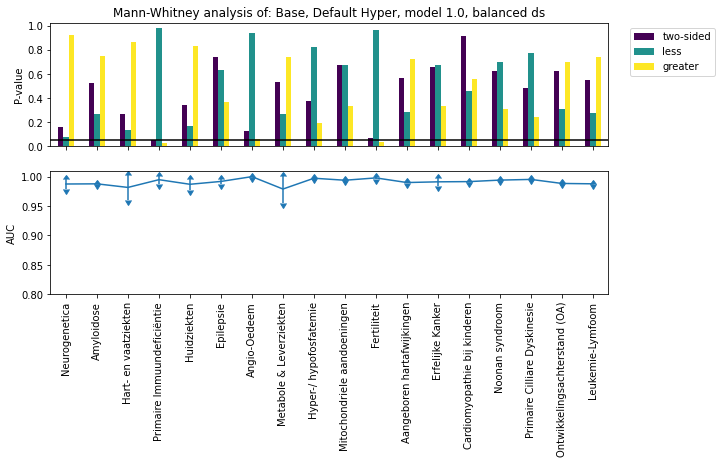

In [49]:
fig, axes = plt.subplots(nrows=2, figsize=(200,100), sharex=True)
umcg_genepanel_analysis.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title=f'Mann-Whitney analysis of: {curr_setup}', ax=axes[0])
axes[0].hlines(y=0.05,xmin=-10,xmax=100)
axes[0].set_ylabel('P-value')
axes[0].set_xlabel('Panel')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.2,1))
axes[1].errorbar(y=y_mean, x=x, yerr=y_std, uplims=True, lolims=True)
axes[1].set_ylabel('AUC')
axes[1].set_ylim((0.8,1.01))
plt.xticks(rotation=90)
plt.show()

In [50]:
categories = umcg_genepanel_analysis['compared_to'].unique()
pallette = viridis(umcg_genepanel_analysis.shape[0])
colormap = dict(zip(categories, pallette))
umcg_genepanel_analysis['color'] = umcg_genepanel_analysis['compared_to'].map(colormap)

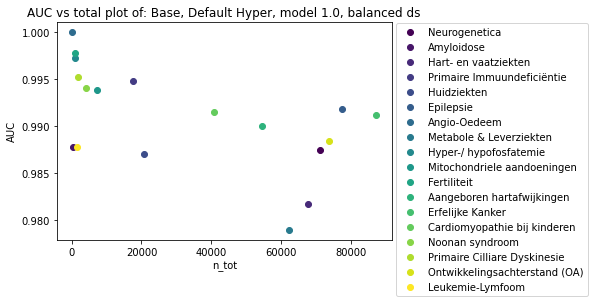

In [51]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_tot'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs total plot of: {curr_setup}')
plt.xlabel('n_tot')
plt.ylabel('AUC')
plt.show()

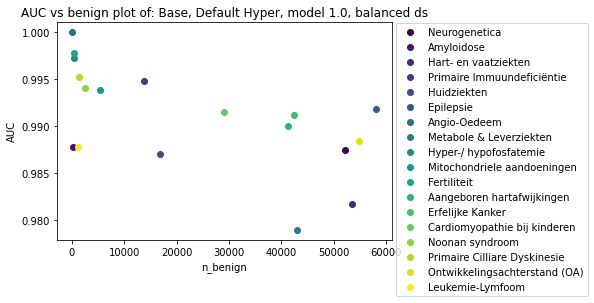

In [52]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_benign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs benign plot of: {curr_setup}')
plt.xlabel('n_benign')
plt.ylabel('AUC')
plt.show()

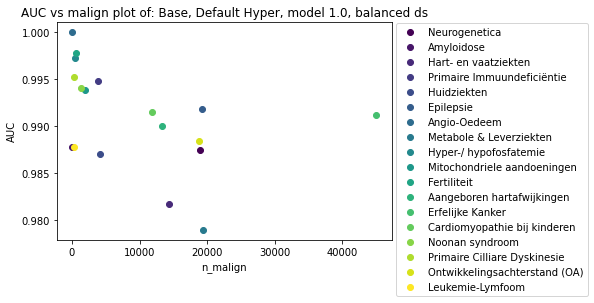

In [53]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_malign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs malign plot of: {curr_setup}')
plt.xlabel('n_malign')
plt.ylabel('AUC')
plt.show()

### Base | Default hyper | unbalanced ds
[(Back)](#Full-dataset-AUC-analysis)

In [54]:
curr_setup = 'Base, Default Hyper, model 2.0, unbalanced ds'
train_output = read_capice_output('./test_output/model_2_0/default_hyper/result_files/train_defaulthyper_nothres.txt')
test_output = read_capice_output('./test_output/model_2_0/default_hyper/result_files/test_defaulthyper_nothres.txt')
train_output, test_output = auc_analysis_function(train_output, test_output, return_value=True)

AUC analysis of the training dataset reveals AUC: 0.9971556579293329
AUC analysis of the testing dataset reveals AUC: 0.893710301011245


In [55]:
train_output['source'] = 'train'
test_output['source'] = 'test'
full = train_output.append(test_output)
full.drop_duplicates(subset=['chr', 'pos', 'ref', 'alt'], inplace=True)
auc_analysis = analyze_auc_per_gene(full, 'auc_analysis_bdhud.csv')

In [56]:
# The 10 worst performing genes in the new model.

auc_analysis.sort_values(by='auc').head(10)

,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test
2304,DFNA5,0.277778,0.000000,0.000000,1.000000,0.000000,36,1,37,37,0
2330,CEACAM16,0.408257,0.000000,0.000000,1.000000,0.000000,218,1,219,216,3
2280,GJB3,0.534091,0.000000,0.000000,1.000000,0.000000,88,2,90,90,0
2211,CEP104,0.549296,0.055556,0.500000,0.500000,0.029412,71,2,73,61,12
2316,NTRK2,0.571429,0.000000,0.000000,1.000000,0.000000,14,1,15,14,1
2186,KCNE2,0.572139,0.250000,0.333333,0.666667,0.200000,67,3,70,68,2
2268,LDB3,0.582375,0.000000,0.000000,1.000000,0.000000,522,1,523,514,9
2214,GFM2,0.600877,0.000000,0.000000,1.000000,0.000000,114,2,116,107,9
2290,NRXN3,0.629630,0.000000,0.000000,1.000000,0.000000,567,1,568,565,3
2325,KBTBD13,0.642857,0.000000,0.000000,1.000000,0.000000,98,1,99,88,11


In [57]:
umcg_genepanel_analysis = genepanel_analysis(genepanels, auc_analysis)
umcg_genepanel_analysis

,two-sided,less,greater,category,compared_to,mean,std,n_benign,n_malign,n_tot,n_train
0,0.201015,0.100508,0.901326,all,Neurogenetica,0.988259,0.006693,52131,18971,71102,68303
1,0.395886,0.197943,0.811751,all,Amyloidose,0.986220,0.000000,207,31,238,227
2,0.353308,0.176654,0.825829,all,Hart- en vaatziekten,0.980867,0.022936,53527,14330,67857,64848
3,0.062432,0.969686,0.031216,all,Primaire Immuundeficiëntie,0.995094,0.005873,13788,3803,17591,16948
4,0.487275,0.243638,0.760413,all,Huidziekten,0.988588,0.008058,16776,4087,20863,20276
5,0.926552,0.463276,0.541030,all,Epilepsie,0.991155,0.004596,58124,19290,77414,75532
6,0.128232,0.940203,0.064116,all,Angio-Oedeem,1.000000,0.000000,61,18,79,76
7,0.659792,0.329896,0.676584,all,Metabole & Leverziekten,0.983356,0.017183,43002,19365,62367,59695
8,0.376499,0.821146,0.188249,all,Hyper-/ hypofosfatemie,0.997061,0.000000,516,508,1024,987
9,0.620427,0.702159,0.310214,all,Mitochondriele aandoeningen,0.994185,0.000000,5305,1891,7196,6981


In [58]:
umcg_genepanel_analysis['mean'].mean()

0.9911311629343881

In [59]:
y_mean = np.array(umcg_genepanel_analysis['mean'])
y_std = np.array(umcg_genepanel_analysis['std'])
x = np.arange(y_mean.size)

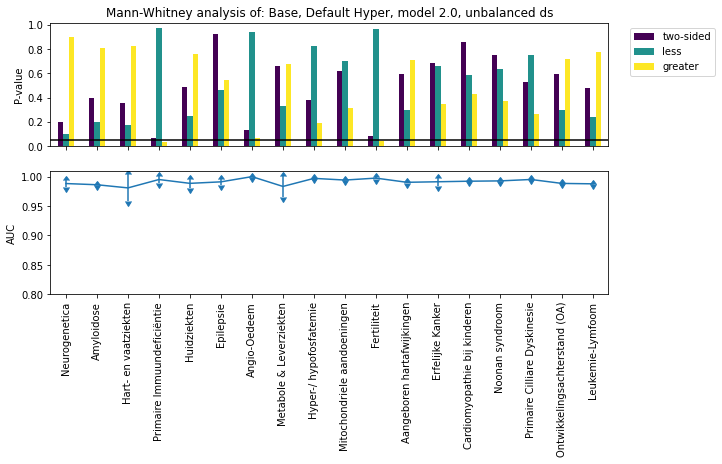

In [60]:
fig, axes = plt.subplots(nrows=2, figsize=(200,100), sharex=True)
umcg_genepanel_analysis.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title=f'Mann-Whitney analysis of: {curr_setup}', ax=axes[0])
axes[0].hlines(y=0.05,xmin=-10,xmax=100)
axes[0].set_ylabel('P-value')
axes[0].set_xlabel('Panel')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.2,1))
axes[1].errorbar(y=y_mean, x=x, yerr=y_std, uplims=True, lolims=True)
axes[1].set_ylabel('AUC')
axes[1].set_ylim((0.8,1.01))
plt.xticks(rotation=90)
plt.show()

In [61]:
categories = umcg_genepanel_analysis['compared_to'].unique()
pallette = viridis(umcg_genepanel_analysis.shape[0])
colormap = dict(zip(categories, pallette))
umcg_genepanel_analysis['color'] = umcg_genepanel_analysis['compared_to'].map(colormap)

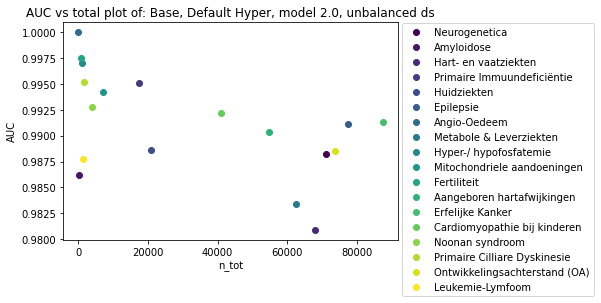

In [62]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_tot'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs total plot of: {curr_setup}')
plt.xlabel('n_tot')
plt.ylabel('AUC')
plt.show()

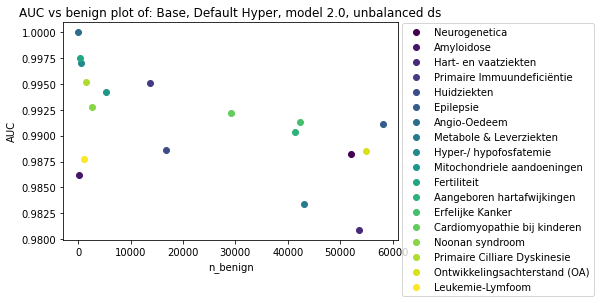

In [63]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_benign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs benign plot of: {curr_setup}')
plt.xlabel('n_benign')
plt.ylabel('AUC')
plt.show()

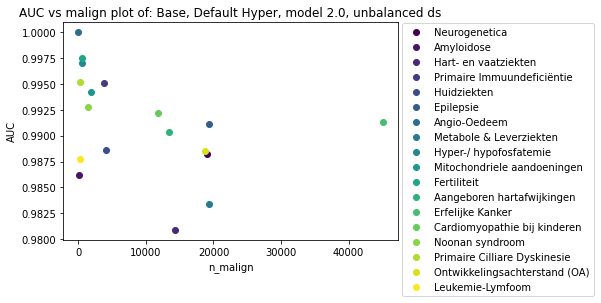

In [64]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_malign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs malign plot of: {curr_setup}')
plt.xlabel('n_malign')
plt.ylabel('AUC')
plt.show()

### Base | Default hyper | balanced ds
[(Back)](#Full-dataset-AUC-analysis)

In [65]:
curr_setup = 'Base, Default Hyper, model 2.0, balanced ds'
train_output = read_capice_output('./test_output/model_2_0/default_hyper/result_files/train_model2_defaulthyper_balancedds.txt')
test_output = read_capice_output('./test_output/model_2_0/default_hyper/result_files/test_model2_defaulthyper_balancedds.txt')
train_output, test_output = auc_analysis_function(train_output, test_output, return_value=True)

AUC analysis of the training dataset reveals AUC: 0.9664171030412587
AUC analysis of the testing dataset reveals AUC: 0.9394584540957758


In [66]:
train_output['source'] = 'train'
test_output['source'] = 'test'
full = train_output.append(test_output)
full.drop_duplicates(subset=['chr','pos','ref','alt'], inplace=True)
auc_analysis = analyze_auc_per_gene(full, 'auc_analysis_bdhbd.csv')  # Base Default Hyperparameters Balanced Dataset

In [67]:
# The 10 worst performing genes in the new model.

auc_analysis.sort_values(by='auc').head(10)

,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test
2310,SMPX,0.000000,0.000000,0.0,1.0,0.000000,5,1,6,5,1
2273,MEIS2,0.000000,0.333333,1.0,0.0,0.200000,4,1,5,4,1
1269,SORD,0.000000,0.500000,1.0,0.0,0.333333,2,1,3,2,1
2330,LIPE,0.000000,0.500000,1.0,0.0,0.333333,2,1,3,3,0
1787,MFAP5,0.050000,0.000000,0.0,1.0,0.000000,40,1,41,38,3
2303,ZNF711,0.080000,0.000000,0.0,1.0,0.000000,25,1,26,25,1
1256,MAG,0.166667,0.285714,1.0,0.0,0.166667,6,1,7,7,0
2069,ANKRD26,0.207547,0.000000,0.0,1.0,0.000000,53,1,54,54,0
2073,TUBB1,0.219512,0.058824,1.0,0.0,0.030303,41,1,42,42,0
2344,EDN3,0.250000,0.000000,0.0,1.0,0.000000,8,1,9,8,1


In [68]:
umcg_genepanel_analysis = genepanel_analysis(genepanels, auc_analysis, is_balanced_loc='./datafiles/train_balanced_dataset.tsv.gz')
umcg_genepanel_analysis

,two-sided,less,greater,category,compared_to,mean,std,n_benign,n_malign,n_tot,n_train
0,0.014674,0.992873,0.007337,all,Neurogenetica,0.950119,0.013464,4702,11312,16014,16014
1,0.620671,0.310336,0.702030,all,Amyloidose,0.929387,0.000000,28,22,50,50
2,0.000795,0.000397,0.999616,all,Hart- en vaatziekten,0.870646,0.113122,5973,8410,14383,14383
3,0.994824,0.502588,0.502588,all,Primaire Immuundeficiëntie,0.938632,0.018572,1356,2159,3515,3515
4,0.432460,0.787554,0.216230,all,Huidziekten,0.941523,0.007881,1382,2530,3912,3912
5,0.063849,0.968844,0.031924,all,Epilepsie,0.949477,0.016418,4160,13236,17396,17396
6,0.203161,0.904554,0.101580,all,Angio-Oedeem,0.963492,0.000000,3,12,15,15
7,0.836416,0.418208,0.588791,all,Metabole & Leverziekten,0.933096,0.013600,3361,11780,15141,15141
8,0.179176,0.915998,0.089588,all,Hyper-/ hypofosfatemie,0.967763,0.000000,32,342,374,374
9,0.229403,0.892002,0.114702,all,Mitochondriele aandoeningen,0.960067,0.000000,469,1282,1751,1751


In [69]:
umcg_genepanel_analysis['mean'].mean()

0.9330614343127179

In [70]:
y_mean = np.array(umcg_genepanel_analysis['mean'])
y_std = np.array(umcg_genepanel_analysis['std'])
x = np.arange(y_mean.size)

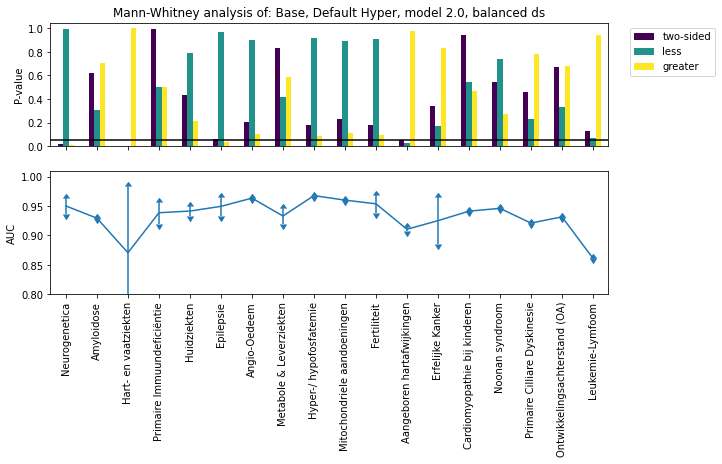

In [71]:
fig, axes = plt.subplots(nrows=2, figsize=(200,100), sharex=True)
umcg_genepanel_analysis.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title=f'Mann-Whitney analysis of: {curr_setup}', ax=axes[0])
axes[0].hlines(y=0.05,xmin=-10,xmax=100)
axes[0].set_ylabel('P-value')
axes[0].set_xlabel('Panel')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.2,1))
axes[1].errorbar(y=y_mean, x=x, yerr=y_std, uplims=True, lolims=True)
axes[1].set_ylabel('AUC')
axes[1].set_ylim((0.8,1.01))
plt.xticks(rotation=90)
plt.show()

In [72]:
categories = umcg_genepanel_analysis['compared_to'].unique()
pallette = viridis(umcg_genepanel_analysis.shape[0])
colormap = dict(zip(categories, pallette))
umcg_genepanel_analysis['color'] = umcg_genepanel_analysis['compared_to'].map(colormap)

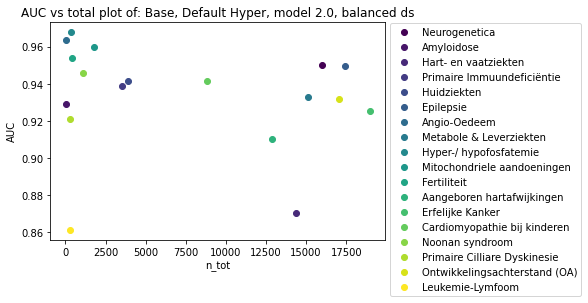

In [73]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_tot'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs total plot of: {curr_setup}')
plt.xlabel('n_tot')
plt.ylabel('AUC')
plt.show()

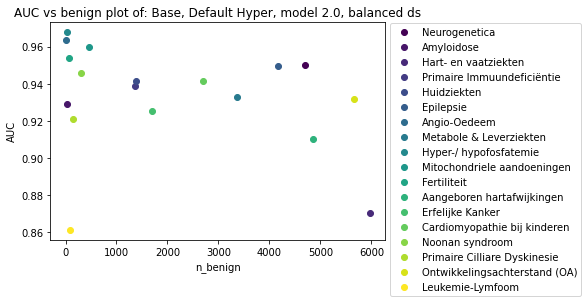

In [74]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_benign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs benign plot of: {curr_setup}')
plt.xlabel('n_benign')
plt.ylabel('AUC')
plt.show()

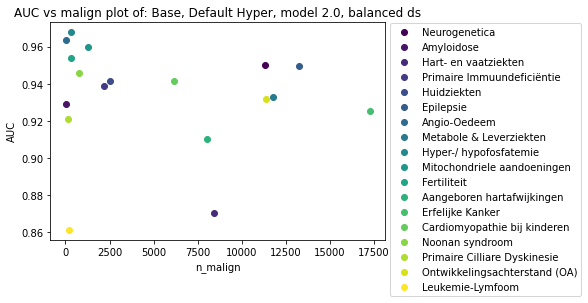

In [75]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_malign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs malign plot of: {curr_setup}')
plt.xlabel('n_malign')
plt.ylabel('AUC')
plt.show()

# Preparing training data for Cardiovascular
[Index](#Index)

In [76]:
hevz = []
for key, value in genepanels['Hart- en vaatziekten'].items():
    for gene in value:
        if gene not in hevz:
            hevz.append(gene)
hevz

['ABCC8',
 'ACTA2',
 'ACVRL1',
 'AQP1',
 'ATP13A3',
 'BMPR1B',
 'BMPR2',
 'CAV1',
 'EIF2AK4',
 'ENG',
 'GDF2',
 'GGCX',
 'KCNA5',
 'KCNK3',
 'KDR',
 'KLF2',
 'KLK1',
 'SMAD4',
 'SMAD9',
 'SOX17',
 'TBX4',
 'ABCC9',
 'AKAP9',
 'ANK2',
 'ASPH',
 'CACNA1C',
 'CACNA1D',
 'CACNA2D1',
 'CACNB2',
 'CALM1',
 'CALM2',
 'CALM3',
 'CASQ2',
 'CAV3',
 'GJA5',
 'GNB2',
 'GPD1L',
 'HCN4',
 'JPH2',
 'KCND3',
 'KCNE1',
 'KCNE2',
 'KCNE3',
 'KCNE1L',
 'KCNH2',
 'KCNJ2',
 'KCNJ5',
 'KCNJ8',
 'KCNQ1',
 'LAMP2',
 'LMNA',
 'MYL4',
 'NKX2-5',
 'NPPA',
 'PKP2',
 'PLN',
 'PPA2',
 'PRKAG2',
 'RANGRF',
 'RYR2',
 'SCN10A',
 'SCN1B',
 'SCN2B',
 'SCN3B',
 'SCN4B',
 'SCN5A',
 'SLMAP',
 'SNTA1',
 'TECRL',
 'TNNI3K',
 'TNNT2',
 'TRDN',
 'TRPM4',
 'CYP27A1',
 'SAR1B',
 'APOE',
 'ABCA1',
 'ABCG5',
 'ABCG8',
 'ANGPTL3',
 'APOA1',
 'APOA5',
 'APOB',
 'APOC2',
 'APOC3',
 'CETP',
 'CYP7A1',
 'GPD1',
 'GPIHBP1',
 'LCAT',
 'LDLR',
 'LDLRAP1',
 'LIPA',
 'LIPC',
 'LIPG',
 'LMF1',
 'LPL',
 'MTTP',
 'MYLIP',
 'PCSK9',
 'SCARB1',


In [77]:
training_dataset = pd.read_csv('./datafiles/train.txt.gz', sep='\t', low_memory=False)
training_dataset

,#Chrom,Allergy/Immunology/Infectious,Alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,revel,sift,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight
0,14,False,G,CodingTranscript,False,False,CCDS9787.1,806.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,5.843,False,1.0
1,20,False,T,CodingTranscript,True,False,CCDS13112.1,1899.0,True,"frameshift,stop_gained",...,NaN,NaN,vkgl,NaN,NaN,False,1.000,4.670,False,1.0
2,20,False,C,CodingTranscript,True,False,CCDS13112.1,2118.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,5.043,False,1.0
3,20,False,A,CodingTranscript,True,False,CCDS13112.1,1586.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,6.221,False,1.0
4,20,False,A,Intergenic,True,False,NaN,NaN,True,downstream,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,6.368,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334596,17,False,A,CodingTranscript,False,False,CCDS32642.1,1563.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,6.031,False,0.8
334597,17,False,T,CodingTranscript,False,False,CCDS32642.1,2029.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,4.100,False,0.8
334598,10,False,T,CodingTranscript,False,False,CCDS7431.1,1216.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,5.852,False,0.8
334599,2,False,T,CodingTranscript,False,False,CCDS2382.1,2998.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.031,2.213,False,0.8


In [78]:
for c in training_dataset.columns:
    print(c)

#Chrom
Allergy/Immunology/Infectious
Alt
AnnoType
Audiologic/Otolaryngologic
Biochemical
CCDS
CDSpos
Cardiovascular
ConsDetail
ConsScore
Consequence
CpG
Craniofacial
Dental
Dermatologic
Dist2Mutation
Domain
Dst2SplType
Dst2Splice
EncExp
EncH3K27Ac
EncH3K4Me1
EncH3K4Me3
EncNucleo
EncOCC
EncOCCombPVal
EncOCDNasePVal
EncOCDNaseSig
EncOCFairePVal
EncOCFaireSig
EncOCctcfPVal
EncOCctcfSig
EncOCmycPVal
EncOCmycSig
EncOCpolIIPVal
EncOCpolIISig
Endocrine
Exon
FeatureID
Freq10000bp
Freq1000bp
Freq100bp
GC
Gastrointestinal
GeneID
GeneName
General
Genitourinary
GerpN
GerpRS
GerpRSpval
GerpS
Grantham
Hematologic
Intron
Length
Musculoskeletal
Neurologic
Obstetric
Oncologic
Ophthalmologic
PHRED
PolyPhenCat
PolyPhenVal
Pos
Pulmonary
Rare10000bp
Rare1000bp
Rare100bp
RawScore
Ref
Renal
SIFTcat
SIFTval
Segway
Sngl10000bp
Sngl1000bp
Sngl100bp
Stars
TFBS
TFBSPeaks
TFBSPeaksMax
Type
allvalid
bStatistic
binarized_label
cDNApos
cHmmBivFlnk
cHmmEnh
cHmmEnhBiv
cHmmEnhG
cHmmHet
cHmmQuies
cHmmReprPC
cHmmReprPCWk


In [79]:
training_dataset[training_dataset['GeneName'].isin(hevz)]

,#Chrom,Allergy/Immunology/Infectious,Alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,revel,sift,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight
18,15,False,AA,CodingTranscript,False,False,CCDS42016.1,1737.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,True,1.000,4.472,False,1.0
21,7,False,GG,CodingTranscript,False,False,CCDS5928.1,431.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,True,0.995,3.815,False,1.0
22,11,False,G,CodingTranscript,False,False,CCDS53621.1,884.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,4.533,False,1.0
23,11,False,A,CodingTranscript,False,False,CCDS53621.1,2532.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,5.262,False,1.0
24,11,False,AGC,CodingTranscript,False,False,CCDS53621.1,3685.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,True,1.000,3.135,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334579,12,False,A,CodingTranscript,False,False,CCDS8693.1,2080.0,True,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,3.492,False,0.8
334580,12,False,T,CodingTranscript,False,False,CCDS8693.1,1529.0,True,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,5.757,False,0.8
334581,12,False,C,CodingTranscript,False,False,CCDS8693.1,1119.0,True,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,4.145,False,0.8
334582,12,False,CATTTTCAT,CodingTranscript,False,False,CCDS8693.1,1034.0,True,"frameshift,stop_gained",...,NaN,NaN,unknown,NaN,NaN,False,1.000,0.938,False,0.8


In [80]:
filename = './datafiles/cardiovascular.txt.gz'
if not os.path.isfile(filename):
    training_dataset[training_dataset['GeneName'].isin(hevz)].to_csv('./datafiles/cardiovascular.txt.gz', compression='gzip', index=False, sep='\t')

# Preparing data for Dyslipid.
[Index](#Index)

In [81]:
dyslipid_related = []
for key, value in genepanels['Hart- en vaatziekten'].items():
    if key.lower().startswith('dyslipid'):
        for gene in value:
            if gene not in dyslipid_related:
                dyslipid_related.append(gene)
dyslipid_related

['CYP27A1',
 'SAR1B',
 'APOE',
 'ABCA1',
 'ABCG5',
 'ABCG8',
 'ANGPTL3',
 'APOA1',
 'APOA5',
 'APOB',
 'APOC2',
 'APOC3',
 'CETP',
 'CYP7A1',
 'GPD1',
 'GPIHBP1',
 'LCAT',
 'LDLR',
 'LDLRAP1',
 'LIPA',
 'LIPC',
 'LIPG',
 'LMF1',
 'LPL',
 'MTTP',
 'MYLIP',
 'PCSK9',
 'SCARB1',
 'SLCO1B1',
 'STAP1']

In [82]:
training_dataset[training_dataset['GeneName'].isin(dyslipid_related)]

,#Chrom,Allergy/Immunology/Infectious,Alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,revel,sift,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight
142,16,False,T,CodingTranscript,False,False,CCDS10772.1,848.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.928,2.614,False,1.0
148,19,False,CCGGCGAGGTGCAGGCCATGCT,CodingTranscript,False,False,CCDS12647.1,409.0,True,protein_altering,...,NaN,NaN,vkgl,NaN,NaN,True,0.863,0.839,False,1.0
149,2,False,C,CodingTranscript,False,False,CCDS1703.1,13028.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.000,0.058,False,1.0
150,2,False,G,CodingTranscript,False,False,CCDS1703.1,28.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.021,-0.103,False,1.0
151,2,False,C,CodingTranscript,False,False,CCDS1703.1,2534.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.653,0.251,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334284,12,False,T,CodingTranscript,False,False,CCDS8685.1,1093.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.999,3.072,False,0.8
334285,12,False,A,CodingTranscript,False,False,CCDS8685.1,1475.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.580,0.563,False,0.8
334286,12,False,T,CodingTranscript,False,False,CCDS8685.1,1537.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.003,0.643,False,0.8
334287,12,False,G,CodingTranscript,False,False,CCDS8685.1,1553.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.510,2.765,False,0.8


In [83]:
filename = './datafiles/dyslipid.txt.gz'
if not os.path.isfile(filename):
    training_dataset[training_dataset['GeneName'].isin(dyslipid_related)].to_csv(filename, compression='gzip', index=False, sep='\t')

# Preparing data for Neurogenetics.
[Index](#Index)

In [84]:
neuro = []
for key, value in genepanels['Neurogenetica'].items():
    for gene in value:
        if gene not in neuro:
            neuro.append(gene)
neuro

['APP',
 'APOE',
 'CHMP2B',
 'CSF1R',
 'FUS',
 'GRN',
 'MAPT',
 'NPC1',
 'PRNP',
 'PSEN1',
 'PSEN2',
 'SIGMAR1',
 'SORL1',
 'TARDBP',
 'TREM2',
 'UBE3A',
 'UBQLN2',
 'VCP',
 'ADH1C',
 'ATP13A2',
 'ATP1A3',
 'DNAJC13',
 'DNAJC6',
 'EIF4G1',
 'FBXO7',
 'GBA',
 'GIGYF2',
 'HTRA2',
 'LRRK2',
 'PARK2',
 'PARK7',
 'PINK1',
 'PLA2G6',
 'PRKRA',
 'SLC6A3',
 'SNCA',
 'SYNJ1',
 'TAF1',
 'UCHL1',
 'VPS35',
 'C19orf12',
 'CP',
 'FA2H',
 'FTL',
 'PANK2',
 'SLC30A10',
 'WDR45',
 'AP1S2',
 'FGF17',
 'FOXC1',
 'LAMC1',
 'NID1',
 'ZIC1',
 'ZIC4',
 'ADCK3',
 'ADCY5',
 'AMT',
 'ANO3',
 'ARHGEF9',
 'ASAH1',
 'ATM',
 'ATP7A',
 'ATP7B',
 'BRAT1',
 'CACNA1A',
 'CACNA1B',
 'CACNB4',
 'CAMTA1',
 'CARS2',
 'CASR',
 'CDKL5',
 'CERS1',
 'CHD2',
 'CLCN2',
 'CLN3',
 'CLN5',
 'CLN6',
 'CLN8',
 'CNTN2',
 'CSTB',
 'CYP27A1',
 'DNAJC5',
 'EFHC1',
 'EIF2B5',
 'EPM2A',
 'FOLR1',
 'FOXG1',
 'GABRA1',
 'GABRD',
 'GABRG2',
 'GALC',
 'GCSH',
 'GFAP',
 'GLDC',
 'GLRA1',
 'GLRB',
 'GNAO1',
 'GOSR2',
 'HEXA',
 'HEXB',
 'KCNC1',

In [85]:
training_dataset[training_dataset['GeneName'].isin(neuro)]

,#Chrom,Allergy/Immunology/Infectious,Alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,revel,sift,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight
49,6,False,T,CodingTranscript,False,False,CCDS5004.1,1837.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,5.778,False,1.0
114,3,False,AT,CodingTranscript,False,False,CCDS2925.1,666.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,True,1.000,5.747,False,1.0
128,2,False,G,CodingTranscript,True,True,CCDS2419.1,398.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,4.997,False,1.0
129,2,False,C,CodingTranscript,True,True,CCDS2419.1,940.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,3.298,False,1.0
143,15,False,TT,CodingTranscript,False,False,CCDS42029.1,1207.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,True,1.000,5.600,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334455,11,False,A,CodingTranscript,False,False,CCDS31452.1,163.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,5.586,False,0.8
334511,10,False,A,CodingTranscript,False,False,CCDS31314.1,1381.0,False,stop_gained,...,0.173,NaN,unknown,NaN,NaN,False,1.000,3.144,False,0.8
334512,10,False,A,CodingTranscript,False,False,CCDS31314.1,1165.0,False,"splice,stop_gained",...,NaN,NaN,unknown,NaN,NaN,False,1.000,6.319,False,0.8
334573,X,False,A,CodingTranscript,False,True,CCDS14728.1,230.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,1.741,False,0.8


In [86]:
filename = './datafiles/neurogenetics.txt.gz'
if not os.path.isfile(filename):
    training_dataset[training_dataset['GeneName'].isin(neuro)].to_csv(filename, compression='gzip', index=False, sep='\t')

# Preparing data for Hereditary cancer
[Index](#Index)

In [87]:
hc = []
for key, value in genepanels['Erfelijke Kanker'].items():
    for gene in value:
        if gene not in hc:
            hc.append(gene)
hc

['ATM',
 'BRCA1',
 'BRCA2',
 'CHEK2',
 'PALB2',
 'TP53',
 'EPCAM',
 'MLH1',
 'MSH2',
 'MSH6',
 'MUTYH',
 'PMS2',
 'POLD1',
 'POLE',
 'APC',
 'AXIN2',
 'BMPR1A',
 'ENG',
 'MSH3',
 'NTHL1',
 'PTEN',
 'RNF43',
 'SMAD4',
 'STK11',
 'BRIP1',
 'RAD51C',
 'RAD51D',
 'FH',
 'MAX',
 'MDH2',
 'NF1',
 'RET',
 'SDHA',
 'SDHAF2',
 'SDHB',
 'SDHC',
 'SDHD',
 'TMEM127',
 'VHL',
 'AIP',
 'CDKN1A',
 'CDKN1B',
 'CDKN2B',
 'CDKN2C',
 'MEN1',
 'PRKAR1A',
 'ACD',
 'ACTRT1',
 'BAP1',
 'CDK4',
 'CDKN2A',
 'ERCC2',
 'MITF',
 'POLH',
 'POT1',
 'PTCH1',
 'PTCH2',
 'SUFU',
 'TERF2IP',
 'TERT',
 'DICER1',
 'LZTR1',
 'NF2',
 'SMARCA4',
 'SMARCB1',
 'SMARCE1',
 'TSC1',
 'TSC2',
 'ALK',
 'PHOX2B',
 'WT1',
 'CEBPA',
 'DDX41',
 'GATA2',
 'PAX5',
 'RUNX1',
 'CDH1',
 'CTNNA1',
 'FLCN',
 'MET',
 'PALLD',
 'HOXB13',
 'RB1',
 'EGFR',
 'CDC73',
 'KIT',
 'PDGFRA']

In [88]:
training_dataset[training_dataset['GeneName'].isin(hc)]

,#Chrom,Allergy/Immunology/Infectious,Alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,revel,sift,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight
55,2,False,A,CodingTranscript,False,False,CCDS1836.1,741.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.839,-0.283,False,1.0
56,2,False,TA,CodingTranscript,False,False,CCDS1836.1,1944.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,True,0.001,0.466,False,1.0
57,2,False,CC,CodingTranscript,False,False,CCDS1836.1,3259.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,True,1.000,3.249,False,1.0
58,2,False,C,CodingTranscript,False,False,CCDS1836.1,102.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.000,-0.743,False,1.0
59,2,False,AT,CodingTranscript,False,False,CCDS1836.1,395.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,True,1.000,5.138,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334504,5,False,T,CodingTranscript,False,False,CCDS4107.1,3925.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,3.528,False,0.8
334505,5,False,GACAAAGA,CodingTranscript,False,False,CCDS4107.1,4160.0,False,"frameshift,stop_gained",...,NaN,NaN,unknown,NaN,NaN,False,1.000,5.909,False,0.8
334533,17,False,A,CodingTranscript,False,False,CCDS45646.1,271.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.003,0.639,False,0.8
334534,17,False,A,CodingTranscript,False,False,CCDS45646.1,184.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.003,0.266,False,0.8


In [89]:
filename = './datafiles/hereditarycancer.txt.gz'
if not os.path.isfile(filename):
    training_dataset[training_dataset['GeneName'].isin(hc)].to_csv(filename, compression='gzip', index=False, sep='\t')

# AUC analysis of dyslipid model
[Index](#Index)

In [90]:
test_dyslipid = read_capice_output('./test_output/test_results_dyslipid_correct_threshold.txt')
test_dyslipid

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,BRCA1,STOP_GAINED,34.000,9.999996e-01,Pathogenic,Pathogenic,17,41243705,CTGAG,GCCT
1,BRCA2,FRAME_SHIFT,26.900,9.999989e-01,Pathogenic,Pathogenic,13,32912883,CTG,TT
2,BRCA1,FRAME_SHIFT,22.000,9.999983e-01,Pathogenic,Pathogenic,17,41245330,CTTTA,TTT
3,BRCA1,FRAME_SHIFT,22.000,9.999982e-01,Pathogenic,Pathogenic,17,41245404,GTA,CT
4,BRCA2,FRAME_SHIFT,22.600,9.999980e-01,Pathogenic,Pathogenic,13,32915061,TA,T
...,...,...,...,...,...,...,...,...,...,...
10837,BLOC1S1-RDH5,DOWNSTREAM,8.009,1.597412e-07,Neutral,Neutral,12,56115746,G,C
10838,LOC100289580,UPSTREAM,0.168,7.783050e-08,Neutral,Neutral,16,88801032,G,T
10839,MYHAS,DOWNSTREAM,0.035,6.001463e-08,Neutral,Neutral,17,10442488,G,A
10840,LOC100289580,UPSTREAM,1.856,4.832236e-08,Neutral,Neutral,16,88798720,G,A


# AUC analysis on Specific models

_Note: this balanced / unbalanced dataset is what the model was trained on_

[Cardiovascular, default hyperparameters, balanced dataset.](#Cardiovascular-|-Default-hyper-|-balanced)

[Cardiovascular, default hyperparameters, unbalanced dataset.](#Cardiovascular-|-Default-hyper-|-unbalanced)

[Dyslipid, default hyperparameters, balanced dataset.](#Dyslipid-|-Default-hyper-|-balanced)

[Dyslipid, default hyperparameters, unbalanced dataset.](#Dyslipid-|-Default-hyper-|-unbalanced)

[Hereditary cancer, default hyperparameters, balanced dataset.](#Hereditary-cancer-|-Default-hyper-|-balanced)

[Hereditary cancer, default hyperparameters, unbalanced dataset.](#Hereditary-cancer-|-Default-hyper-|-unbalanced)

[Neurogenetics, default hyperparameters, balanced dataset.](#Neurogenetics-|-Default-hyper-|-balanced)

[Neurogenetics, default hyperparameters, unbalanced dataset.](#Neurogenetics-|-Default-hyper-|-unbalanced)

[Index](#Index)

### Cardiovascular | Default hyper | balanced
[Back](#AUC-analysis-on-Specific-models)

In [131]:
training_set = pd.read_csv('./test_output/model_2_0/default_hyper/cardiovascular/balanced/train_balanced_dataset.tsv.gz', sep='\t', low_memory=False)
print(f'There are {training_set.shape[0]} samples in the training set.')

There are 8296 samples in the training set.


In [115]:
curr_setup = 'Cardiovascular, Default Hyper, balanced ds'
train_output = read_capice_output('./test_output/model_2_0/default_hyper/cardiovascular/balanced/cardiovascular_balanced_train.txt')
test_output = read_capice_output('./test_output/model_2_0/default_hyper/cardiovascular/balanced/cardiovascular_balanced_test.txt')
train_output, test_output = auc_analysis_function(train_output, test_output, return_value=True)

AUC analysis of the training dataset reveals AUC: 0.7845349192501072
AUC analysis of the testing dataset reveals AUC: 0.661172122282592


In [116]:
train_output['source'] = 'train'
test_output['source'] = 'test'
full = train_output.append(test_output)
full.drop_duplicates(subset=['chr','pos','ref','alt'], inplace=True)
auc_analysis = analyze_auc_per_gene(full, 'auc_analysis_cardio_balanced.csv')

I am stilling running, done 5%
I am stilling running, done 10%
I am stilling running, done 14%
I am stilling running, done 19%
I am stilling running, done 24%
I am stilling running, done 29%
I am stilling running, done 34%
I am stilling running, done 39%
I am stilling running, done 45%
I am stilling running, done 50%
I am stilling running, done 56%
I am stilling running, done 61%
I am stilling running, done 67%
I am stilling running, done 73%
I am stilling running, done 78%
I am stilling running, done 84%
I am stilling running, done 90%
I am stilling running, done 95%


In [117]:
# The 10 worst performing genes in the new model.

auc_analysis.sort_values(by='auc').head(10)

,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test
874,PIGW,0.0,0.857143,1.000000,0.000000,0.750000,1,3,4,4,0
1941,GRID2,0.0,0.285714,1.000000,0.000000,0.166667,5,1,6,6,0
1966,HIST1H1E,0.0,0.285714,1.000000,0.000000,0.166667,5,1,6,5,1
2310,F2,0.0,0.000000,0.000000,1.000000,0.000000,2,1,3,3,0
1336,TWIST2,0.0,0.666667,1.000000,0.000000,0.500000,1,1,2,2,0
1461,FAR1,0.0,0.666667,1.000000,0.000000,0.500000,1,1,2,2,0
2336,TEX15,0.0,0.000000,0.000000,1.000000,0.000000,3,1,4,4,0
2350,PTH,0.0,0.000000,0.000000,1.000000,0.000000,3,1,4,4,0
1942,PBX1,0.0,0.666667,1.000000,0.000000,0.500000,1,1,2,2,0
2147,KIAA0753,0.0,0.285714,0.333333,0.666667,0.250000,3,3,6,6,0


In [119]:
umcg_genepanel_analysis = genepanel_analysis(genepanels, auc_analysis, is_balanced_loc='./test_output/model_2_0/default_hyper/cardiovascular/balanced/train_balanced_dataset.tsv.gz')
umcg_genepanel_analysis

,two-sided,less,greater,category,compared_to,mean,std,n_benign,n_malign,n_tot,n_train
0,2.324861e-01,0.116243,8.857927e-01,all,Neurogenetica,0.802821,0.038635,45,127,172,172
1,5.018088e-01,0.760216,2.509044e-01,all,Amyloidose,0.839725,0.000000,14,20,34,34
2,1.750705e-07,1.000000,8.753523e-08,all,Hart- en vaatziekten,0.902688,0.052966,8138,8845,16983,16983
3,2.403005e-01,0.882428,1.201503e-01,all,Primaire Immuundeficiëntie,0.836119,0.042187,17,86,103,103
4,4.324615e-01,0.216231,7.875536e-01,all,Huidziekten,0.800507,0.033170,140,383,523,523
5,8.007128e-02,0.040036,9.608901e-01,all,Epilepsie,0.769002,0.085014,85,30,115,115
6,3.580458e-01,0.830071,1.790229e-01,all,Angio-Oedeem,0.856825,0.000000,0,0,0,0
7,8.084788e-01,0.404239,6.027007e-01,all,Metabole & Leverziekten,0.792870,0.049094,623,1976,2599,2599
8,5.478754e-01,0.737708,2.739377e-01,all,Hyper-/ hypofosfatemie,0.833300,0.000000,0,0,0,0
9,4.367483e-01,0.791904,2.183741e-01,all,Mitochondriele aandoeningen,0.848092,0.000000,4,53,57,57


In [120]:
umcg_genepanel_analysis['mean'].mean()

0.8159409876169602

In [128]:
y_mean = np.array(umcg_genepanel_analysis['mean'])
y_std = np.array(umcg_genepanel_analysis['std'])
x = np.arange(y_mean.size)

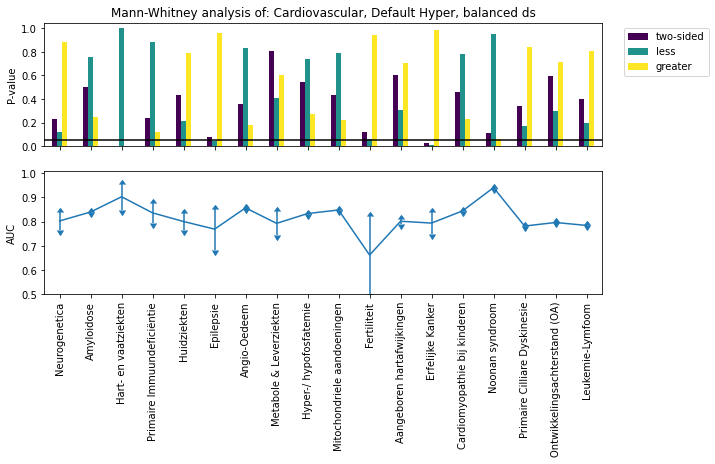

In [129]:
fig, axes = plt.subplots(nrows=2, figsize=(200,100), sharex=True)
umcg_genepanel_analysis.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title=f'Mann-Whitney analysis of: {curr_setup}', ax=axes[0])
axes[0].hlines(y=0.05,xmin=-10,xmax=100)
axes[0].set_ylabel('P-value')
axes[0].set_xlabel('Panel')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.2,1))
axes[1].errorbar(y=y_mean, x=x, yerr=y_std, uplims=True, lolims=True)
axes[1].set_ylabel('AUC')
axes[1].set_ylim((0.5,1.01))
plt.xticks(rotation=90)
plt.show()

In [123]:
categories = umcg_genepanel_analysis['compared_to'].unique()
pallette = viridis(umcg_genepanel_analysis.shape[0])
colormap = dict(zip(categories, pallette))
umcg_genepanel_analysis['color'] = umcg_genepanel_analysis['compared_to'].map(colormap)

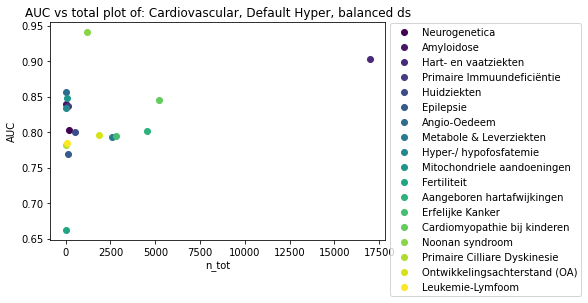

In [124]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_tot'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs total plot of: {curr_setup}')
plt.xlabel('n_tot')
plt.ylabel('AUC')
plt.show()

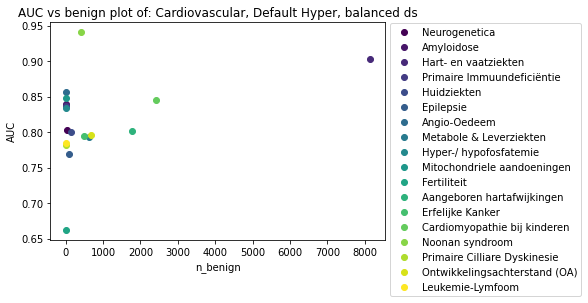

In [125]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_benign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs benign plot of: {curr_setup}')
plt.xlabel('n_benign')
plt.ylabel('AUC')
plt.show()

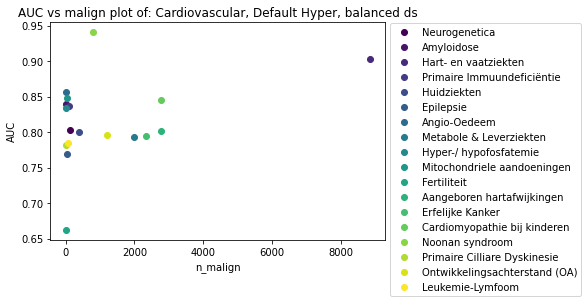

In [126]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_malign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs malign plot of: {curr_setup}')
plt.xlabel('n_malign')
plt.ylabel('AUC')
plt.show()

### Cardiovascular | Default hyper | unbalanced
[Back](#AUC-analysis-on-Specific-models)

In [137]:
training_set = pd.read_csv('./datafiles/cardiovascular.txt.gz', sep='\t', low_memory=False)
print(f'There are {training_set.shape[0]} samples in the training set.')

There are 35058 samples in the training set.


In [141]:
curr_setup = 'Cardiovascular, Default Hyper, unbalanced ds'
train_output = read_capice_output('./test_output/model_2_0/default_hyper/cardiovascular/unbalanced/cardiovascular_unbalanced_train.txt')
test_output = read_capice_output('./test_output/model_2_0/default_hyper/cardiovascular/unbalanced/cardiovascular_unbalanced_test.txt')
train_output, test_output = auc_analysis_function(train_output, test_output, return_value=True)

AUC analysis of the training dataset reveals AUC: 0.9166123108611142
AUC analysis of the testing dataset reveals AUC: 0.658635256028288


In [142]:
train_output['source'] = 'train'
test_output['source'] = 'test'
full = train_output.append(test_output)
full.drop_duplicates(subset=['chr','pos','ref','alt'], inplace=True)
auc_analysis = analyze_auc_per_gene(full, 'auc_analysis_cardio_unbalanced.csv')

I am stilling running, done 4%
I am stilling running, done 9%
I am stilling running, done 14%
I am stilling running, done 18%
I am stilling running, done 23%
I am stilling running, done 28%
I am stilling running, done 33%
I am stilling running, done 39%
I am stilling running, done 45%
I am stilling running, done 50%
I am stilling running, done 56%
I am stilling running, done 61%
I am stilling running, done 67%
I am stilling running, done 73%
I am stilling running, done 78%
I am stilling running, done 84%
I am stilling running, done 90%
I am stilling running, done 96%


In [143]:
# The 10 worst performing genes in the new model.

auc_analysis.sort_values(by='auc').head(10)

,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test
2342,TRAF3IP1,0.000000,0.000000,0.0,1.0,0.000000,3,1,4,4,0
2282,CDK10,0.000000,0.000000,0.0,1.0,0.000000,1,2,3,3,0
1913,SAA1,0.016393,0.000000,0.0,1.0,0.000000,61,1,62,61,1
922,ASCC1,0.031746,0.000000,0.0,1.0,0.000000,63,1,64,56,8
863,TNC,0.060071,0.000000,0.0,1.0,0.000000,283,1,284,278,6
1470,CA4,0.078431,0.000000,0.0,1.0,0.000000,153,1,154,153,1
577,KIAA0196,0.094771,0.000000,0.0,1.0,0.000000,306,1,307,299,8
1089,UBQLN2,0.122449,0.000000,0.0,1.0,0.000000,49,1,50,50,0
411,TBX6,0.142857,0.137931,1.0,0.0,0.074074,28,2,30,23,7
2157,GRIA4,0.142857,0.000000,0.0,1.0,0.000000,14,1,15,15,0


In [144]:
umcg_genepanel_analysis = genepanel_analysis(genepanels, auc_analysis, is_balanced_loc='./test_output/model_2_0/default_hyper/cardiovascular/balanced/train_balanced_dataset.tsv.gz')
umcg_genepanel_analysis

,two-sided,less,greater,category,compared_to,mean,std,n_benign,n_malign,n_tot,n_train
0,2.367856e-02,0.011839,9.884802e-01,all,Neurogenetica,0.905812,0.033701,45,127,172,172
1,4.795632e-01,0.239782,7.710640e-01,all,Amyloidose,0.907546,0.000000,14,20,34,34
2,7.144458e-08,1.000000,3.572229e-08,all,Hart- en vaatziekten,0.979572,0.026341,8138,8845,16983,16983
3,4.635000e-01,0.772188,2.317500e-01,all,Primaire Immuundeficiëntie,0.938700,0.029048,17,86,103,103
4,1.608902e-02,0.008045,9.922369e-01,all,Huidziekten,0.900377,0.021976,140,383,523,523
5,7.077441e-03,0.003539,9.965747e-01,all,Epilepsie,0.883637,0.088794,85,30,115,115
6,4.367424e-01,0.218371,7.919071e-01,all,Angio-Oedeem,0.904762,0.000000,0,0,0,0
7,3.937364e-01,0.196868,8.080727e-01,all,Metabole & Leverziekten,0.909086,0.039139,623,1976,2599,2599
8,5.716628e-01,0.726065,2.858314e-01,all,Hyper-/ hypofosfatemie,0.948617,0.000000,0,0,0,0
9,7.503693e-01,0.638144,3.751847e-01,all,Mitochondriele aandoeningen,0.943486,0.000000,4,53,57,57


In [145]:
umcg_genepanel_analysis['mean'].mean()

0.9237086079299358

In [146]:
y_mean = np.array(umcg_genepanel_analysis['mean'])
y_std = np.array(umcg_genepanel_analysis['std'])
x = np.arange(y_mean.size)

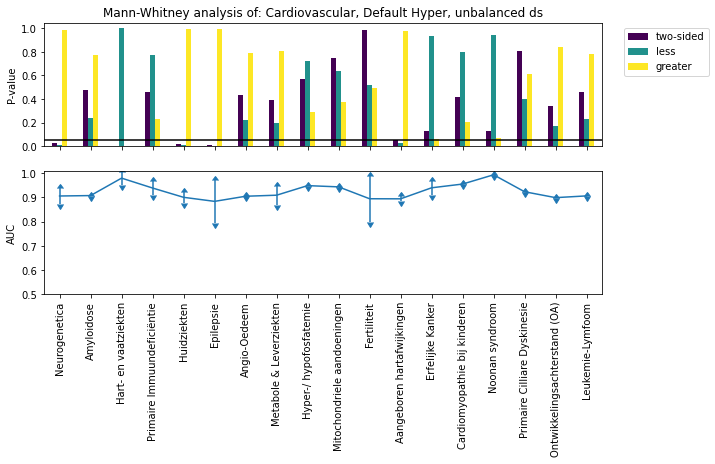

In [147]:
fig, axes = plt.subplots(nrows=2, figsize=(200,100), sharex=True)
umcg_genepanel_analysis.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title=f'Mann-Whitney analysis of: {curr_setup}', ax=axes[0])
axes[0].hlines(y=0.05,xmin=-10,xmax=100)
axes[0].set_ylabel('P-value')
axes[0].set_xlabel('Panel')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.2,1))
axes[1].errorbar(y=y_mean, x=x, yerr=y_std, uplims=True, lolims=True)
axes[1].set_ylabel('AUC')
axes[1].set_ylim((0.5,1.01))
plt.xticks(rotation=90)
plt.show()

In [148]:
categories = umcg_genepanel_analysis['compared_to'].unique()
pallette = viridis(umcg_genepanel_analysis.shape[0])
colormap = dict(zip(categories, pallette))
umcg_genepanel_analysis['color'] = umcg_genepanel_analysis['compared_to'].map(colormap)

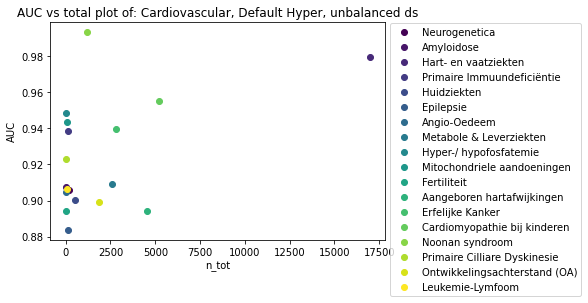

In [149]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_tot'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs total plot of: {curr_setup}')
plt.xlabel('n_tot')
plt.ylabel('AUC')
plt.show()

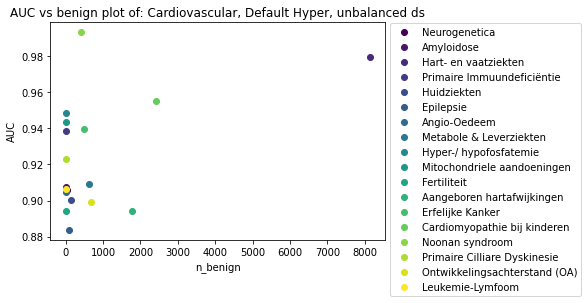

In [150]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_benign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs benign plot of: {curr_setup}')
plt.xlabel('n_benign')
plt.ylabel('AUC')
plt.show()

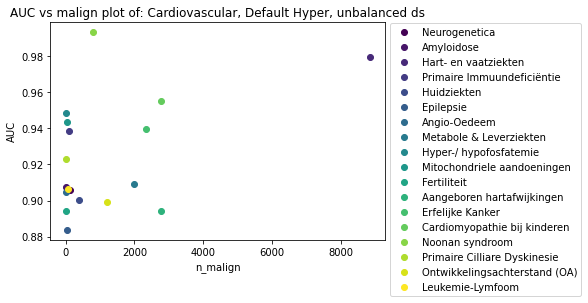

In [151]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_malign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs malign plot of: {curr_setup}')
plt.xlabel('n_malign')
plt.ylabel('AUC')
plt.show()

 ### Dyslipid | Default hyper | balanced
 [Back](#AUC-analysis-on-Specific-models)

In [152]:
training_set = pd.read_csv('./test_output/model_2_0/default_hyper/dyslipid/balanced/train_balanced_dataset.tsv.gz', sep='\t', low_memory=False)
print(f'There are {training_set.shape[0]} samples in the training set.')

There are 1530 samples in the training set.


In [153]:
curr_setup = 'Dyslipid, Default Hyper, balanced ds'
train_output = read_capice_output('./test_output/model_2_0/default_hyper/dyslipid/balanced/dyslipid_balanced_train.txt')
test_output = read_capice_output('./test_output/model_2_0/default_hyper/dyslipid/balanced/dyslipid_balanced_test.txt')
train_output, test_output = auc_analysis_function(train_output, test_output, return_value=True)

AUC analysis of the training dataset reveals AUC: 0.6635443999981026
AUC analysis of the testing dataset reveals AUC: 0.5742350055930735


In [154]:
train_output['source'] = 'train'
test_output['source'] = 'test'
full = train_output.append(test_output)
full.drop_duplicates(subset=['chr','pos','ref','alt'], inplace=True)
auc_analysis = analyze_auc_per_gene(full, 'auc_analysis_dyslipid_balanced.csv')

I am stilling running, done 5%
I am stilling running, done 10%
I am stilling running, done 15%
I am stilling running, done 20%
I am stilling running, done 25%
I am stilling running, done 30%
I am stilling running, done 35%
I am stilling running, done 40%
I am stilling running, done 46%
I am stilling running, done 51%
I am stilling running, done 56%
I am stilling running, done 61%
I am stilling running, done 67%
I am stilling running, done 73%
I am stilling running, done 78%
I am stilling running, done 84%
I am stilling running, done 90%
I am stilling running, done 95%


In [155]:
# The 10 worst performing genes in the new model.

auc_analysis.sort_values(by='auc').head(10)

,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test
484,SNCA,0.0,0.060606,1.0,0.0,0.031250,31,1,32,32,0
2202,PBX1,0.0,0.666667,1.0,0.0,0.500000,1,1,2,2,0
1012,RNF170,0.0,0.071429,1.0,0.0,0.037037,26,1,27,27,0
1919,TWIST2,0.0,0.666667,1.0,0.0,0.500000,1,1,2,2,0
1998,TENM4,0.0,0.066667,1.0,0.0,0.034483,28,1,29,28,1
980,CDK10,0.0,0.800000,1.0,0.0,0.666667,1,2,3,3,0
552,GLUL,0.0,0.100000,1.0,0.0,0.052632,18,1,19,19,0
1705,SSR4,0.0,0.285714,1.0,0.0,0.166667,5,1,6,6,0
1615,FAR1,0.0,0.666667,1.0,0.0,0.500000,1,1,2,2,0
934,ARV1,0.0,0.500000,1.0,0.0,0.333333,2,1,3,3,0


In [156]:
umcg_genepanel_analysis = genepanel_analysis(genepanels, auc_analysis, is_balanced_loc='./test_output/model_2_0/default_hyper/cardiovascular/balanced/train_balanced_dataset.tsv.gz')
umcg_genepanel_analysis

,two-sided,less,greater,category,compared_to,mean,std,n_benign,n_malign,n_tot,n_train
0,0.038102,0.019051,0.981430,all,Neurogenetica,0.618806,0.097035,45,127,172,172
1,0.273147,0.871013,0.136573,all,Amyloidose,0.722522,0.000000,14,20,34,34
2,0.001140,0.999449,0.000570,all,Hart- en vaatziekten,0.786528,0.133717,8138,8845,16983,16983
3,0.205850,0.102925,0.899382,all,Primaire Immuundeficiëntie,0.636262,0.046869,17,86,103,103
4,0.581334,0.290667,0.713763,all,Huidziekten,0.658679,0.021834,140,383,523,523
5,0.377093,0.188547,0.814366,all,Epilepsie,0.636042,0.077654,85,30,115,115
6,0.645841,0.689664,0.322920,all,Angio-Oedeem,0.672540,0.000000,0,0,0,0
7,0.489404,0.760904,0.244702,all,Metabole & Leverziekten,0.685471,0.036536,623,1976,2599,2599
8,0.288920,0.144460,0.863427,all,Hyper-/ hypofosfatemie,0.626876,0.000000,0,0,0,0
9,0.832030,0.416015,0.597720,all,Mitochondriele aandoeningen,0.657848,0.000000,4,53,57,57


In [157]:
umcg_genepanel_analysis['mean'].mean()

0.6678834222011004

In [158]:
y_mean = np.array(umcg_genepanel_analysis['mean'])
y_std = np.array(umcg_genepanel_analysis['std'])
x = np.arange(y_mean.size)

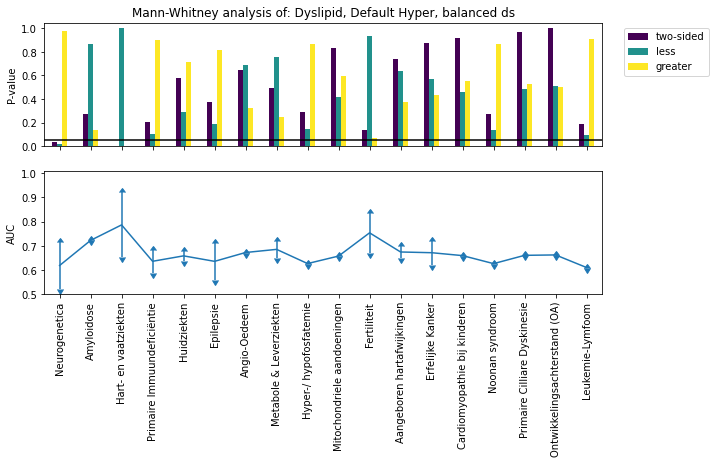

In [159]:
fig, axes = plt.subplots(nrows=2, figsize=(200,100), sharex=True)
umcg_genepanel_analysis.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title=f'Mann-Whitney analysis of: {curr_setup}', ax=axes[0])
axes[0].hlines(y=0.05,xmin=-10,xmax=100)
axes[0].set_ylabel('P-value')
axes[0].set_xlabel('Panel')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.2,1))
axes[1].errorbar(y=y_mean, x=x, yerr=y_std, uplims=True, lolims=True)
axes[1].set_ylabel('AUC')
axes[1].set_ylim((0.5,1.01))
plt.xticks(rotation=90)
plt.show()

In [160]:
categories = umcg_genepanel_analysis['compared_to'].unique()
pallette = viridis(umcg_genepanel_analysis.shape[0])
colormap = dict(zip(categories, pallette))
umcg_genepanel_analysis['color'] = umcg_genepanel_analysis['compared_to'].map(colormap)

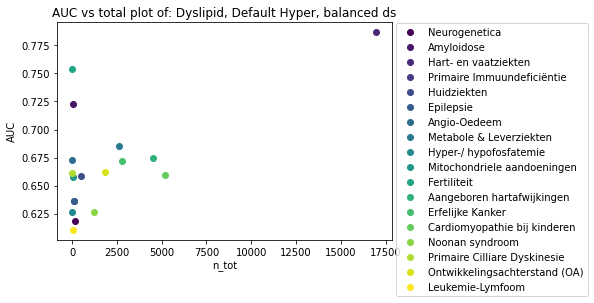

In [161]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_tot'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs total plot of: {curr_setup}')
plt.xlabel('n_tot')
plt.ylabel('AUC')
plt.show()

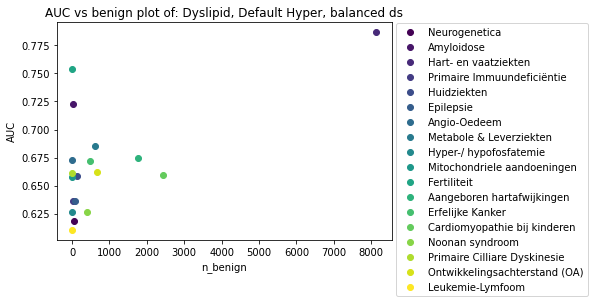

In [162]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_benign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs benign plot of: {curr_setup}')
plt.xlabel('n_benign')
plt.ylabel('AUC')
plt.show()

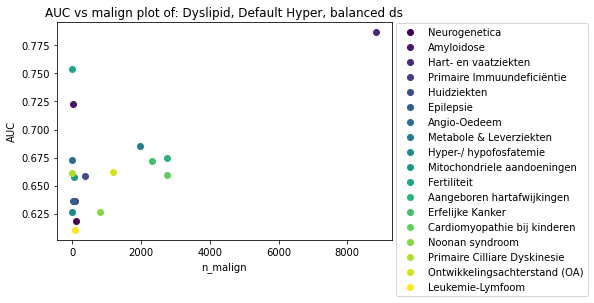

In [163]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_malign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs malign plot of: {curr_setup}')
plt.xlabel('n_malign')
plt.ylabel('AUC')
plt.show()

### Dyslipid | Default hyper | unbalanced
[Back](#AUC-analysis-on-Specific-models)

In [164]:
training_set = pd.read_csv('./datafiles/dyslipid.txt.gz', sep='\t', low_memory=False)
print(f'There are {training_set.shape[0]} samples in the training set.')

There are 5029 samples in the training set.


In [165]:
curr_setup = 'Dyslipid, Default Hyper, unbalanced ds'
train_output = read_capice_output('./test_output/model_2_0/default_hyper/dyslipid/unbalanced/dyslipid_unbalanced_train.txt')
test_output = read_capice_output('./test_output/model_2_0/default_hyper/dyslipid/unbalanced/dyslipid_unbalanced_test.txt')
train_output, test_output = auc_analysis_function(train_output, test_output, return_value=True)

AUC analysis of the training dataset reveals AUC: 0.8353792714855658
AUC analysis of the testing dataset reveals AUC: 0.5906942914443721


In [167]:
train_output['source'] = 'train'
test_output['source'] = 'test'
full = train_output.append(test_output)
full.drop_duplicates(subset=['chr','pos','ref','alt'], inplace=True)
auc_analysis = analyze_auc_per_gene(full, 'auc_analysis_dyslipid_unbalanced.csv')

I am stilling running, done 5%
I am stilling running, done 9%
I am stilling running, done 14%
I am stilling running, done 19%
I am stilling running, done 24%
I am stilling running, done 29%
I am stilling running, done 34%
I am stilling running, done 40%
I am stilling running, done 45%
I am stilling running, done 51%
I am stilling running, done 56%
I am stilling running, done 61%
I am stilling running, done 67%
I am stilling running, done 73%
I am stilling running, done 78%
I am stilling running, done 84%
I am stilling running, done 90%
I am stilling running, done 96%


In [168]:
# The 10 worst performing genes in the new model.

auc_analysis.sort_values(by='auc').head(10)

,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test
2353,F2,0.000000,0.000000,0.000000,1.000000,0.000000,2,1,3,3,0
1853,INTU,0.000000,0.666667,0.666667,0.333333,0.666667,1,3,4,4,0
2151,FAR1,0.000000,0.666667,1.000000,0.000000,0.500000,1,1,2,2,0
1455,ERMAP,0.000000,0.000000,0.000000,1.000000,0.000000,21,1,22,18,4
233,KIAA0196,0.000000,0.000000,0.000000,1.000000,0.000000,306,1,307,299,8
2351,TRAF3IP1,0.000000,0.000000,0.000000,1.000000,0.000000,3,1,4,4,0
2293,SAA1,0.016393,0.000000,0.000000,1.000000,0.000000,61,1,62,61,1
1105,UBQLN2,0.030612,0.000000,0.000000,1.000000,0.000000,49,1,50,50,0
491,ASCC1,0.047619,0.000000,0.000000,1.000000,0.000000,63,1,64,56,8
2195,GRIA4,0.071429,0.000000,0.000000,1.000000,0.000000,14,1,15,15,0


In [169]:
umcg_genepanel_analysis = genepanel_analysis(genepanels, auc_analysis, is_balanced_loc='./test_output/model_2_0/default_hyper/cardiovascular/balanced/train_balanced_dataset.tsv.gz')
umcg_genepanel_analysis

,two-sided,less,greater,category,compared_to,mean,std,n_benign,n_malign,n_tot,n_train
0,0.667612,0.333806,0.669996,all,Neurogenetica,0.860758,0.050208,45,127,172,172
1,0.943635,0.542230,0.471818,all,Amyloidose,0.871059,0.000000,14,20,34,34
2,0.003755,0.998179,0.001877,all,Hart- en vaatziekten,0.932290,0.074335,8138,8845,16983,16983
3,0.922476,0.461238,0.543911,all,Primaire Immuundeficiëntie,0.873093,0.050234,17,86,103,103
4,0.005171,0.002585,0.997517,all,Huidziekten,0.832898,0.022939,140,383,523,523
5,0.015890,0.007945,0.992288,all,Epilepsie,0.830522,0.074652,85,30,115,115
6,0.620661,0.702036,0.310331,all,Angio-Oedeem,0.887302,0.000000,0,0,0,0
7,0.686217,0.343108,0.663469,all,Metabole & Leverziekten,0.858713,0.032595,623,1976,2599,2599
8,0.358030,0.830078,0.179015,all,Hyper-/ hypofosfatemie,0.914752,0.000000,0,0,0,0
9,0.479555,0.771068,0.239777,all,Mitochondriele aandoeningen,0.902504,0.000000,4,53,57,57


In [170]:
umcg_genepanel_analysis['mean'].mean()

0.864607625020695

In [171]:
y_mean = np.array(umcg_genepanel_analysis['mean'])
y_std = np.array(umcg_genepanel_analysis['std'])
x = np.arange(y_mean.size)

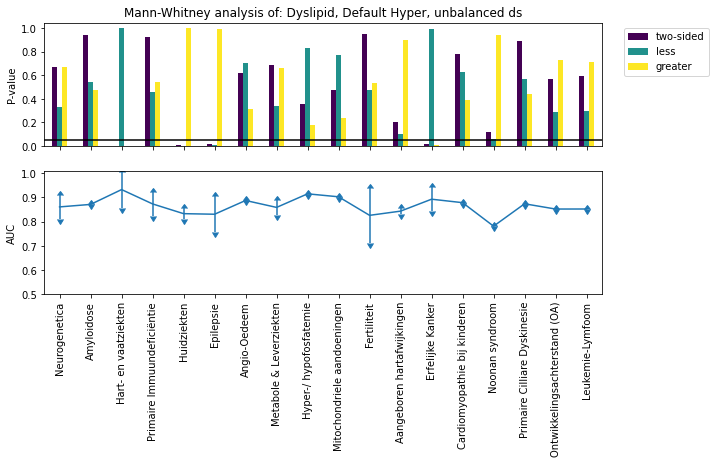

In [172]:
fig, axes = plt.subplots(nrows=2, figsize=(200,100), sharex=True)
umcg_genepanel_analysis.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title=f'Mann-Whitney analysis of: {curr_setup}', ax=axes[0])
axes[0].hlines(y=0.05,xmin=-10,xmax=100)
axes[0].set_ylabel('P-value')
axes[0].set_xlabel('Panel')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.2,1))
axes[1].errorbar(y=y_mean, x=x, yerr=y_std, uplims=True, lolims=True)
axes[1].set_ylabel('AUC')
axes[1].set_ylim((0.5,1.01))
plt.xticks(rotation=90)
plt.show()

In [173]:
categories = umcg_genepanel_analysis['compared_to'].unique()
pallette = viridis(umcg_genepanel_analysis.shape[0])
colormap = dict(zip(categories, pallette))
umcg_genepanel_analysis['color'] = umcg_genepanel_analysis['compared_to'].map(colormap)

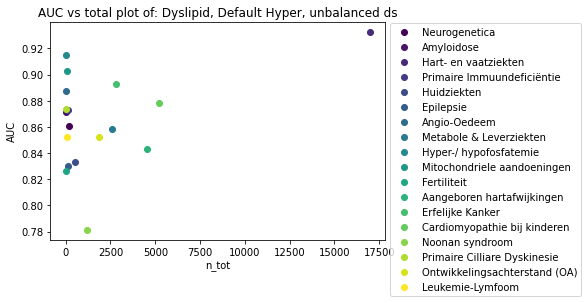

In [174]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_tot'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs total plot of: {curr_setup}')
plt.xlabel('n_tot')
plt.ylabel('AUC')
plt.show()

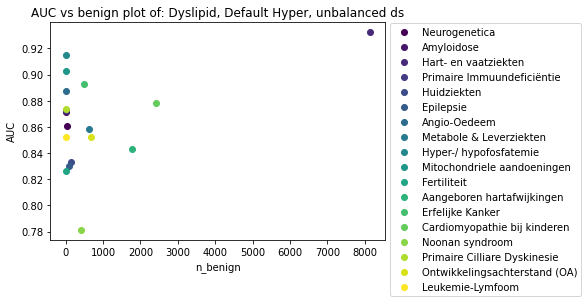

In [175]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_benign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs benign plot of: {curr_setup}')
plt.xlabel('n_benign')
plt.ylabel('AUC')
plt.show()

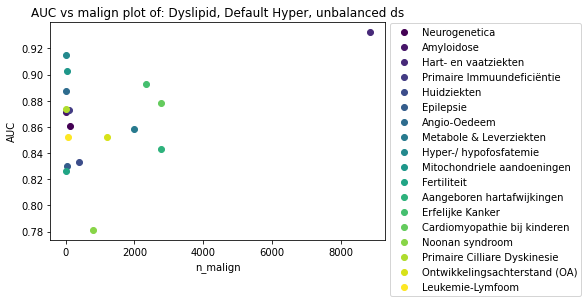

In [176]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_malign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs malign plot of: {curr_setup}')
plt.xlabel('n_malign')
plt.ylabel('AUC')
plt.show()

### Hereditary cancer | Default hyper | balanced
[Back](#AUC-analysis-on-Specific-models)

In [177]:
training_set = pd.read_csv('./test_output/model_2_0/default_hyper/ek/balanced/train_balanced_dataset.tsv.gz', sep='\t', low_memory=False)
print(f'There are {training_set.shape[0]} samples in the training set.')

There are 3442 samples in the training set.


In [178]:
curr_setup = 'Hereditary caner, Default Hyper, balanced ds'
train_output = read_capice_output('./test_output/model_2_0/default_hyper/ek/balanced/ek_balanced_train.txt')
test_output = read_capice_output('./test_output/model_2_0/default_hyper/ek/balanced/ek_balanced_test.txt')
train_output, test_output = auc_analysis_function(train_output, test_output, return_value=True)

AUC analysis of the training dataset reveals AUC: 0.7876012965292702
AUC analysis of the testing dataset reveals AUC: 0.7324935845457557


In [179]:
train_output['source'] = 'train'
test_output['source'] = 'test'
full = train_output.append(test_output)
full.drop_duplicates(subset=['chr','pos','ref','alt'], inplace=True)
auc_analysis = analyze_auc_per_gene(full, 'auc_analysis_hc_balanced.csv')

I am stilling running, done 4%
I am stilling running, done 9%
I am stilling running, done 14%
I am stilling running, done 19%
I am stilling running, done 24%
I am stilling running, done 29%
I am stilling running, done 34%
I am stilling running, done 39%
I am stilling running, done 45%
I am stilling running, done 50%
I am stilling running, done 55%
I am stilling running, done 61%
I am stilling running, done 67%
I am stilling running, done 72%
I am stilling running, done 78%
I am stilling running, done 83%
I am stilling running, done 89%
I am stilling running, done 94%
I am stilling running, done 100%


In [180]:
# The 10 worst performing genes in the new model.

auc_analysis.sort_values(by='auc').head(10)

,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test
1944,UCHL1,0.000000,0.153846,1.0,0.0,0.083333,11,1,12,12,0
1838,MRPS34,0.000000,0.800000,1.0,0.0,0.666667,1,2,3,3,0
2266,BMP1,0.000000,0.000000,0.0,1.0,0.000000,33,1,34,34,0
2335,EFHB,0.000000,0.000000,0.0,1.0,0.000000,1,1,2,2,0
2088,KIAA0556,0.000000,0.666667,1.0,0.0,0.500000,1,1,2,2,0
924,SLC6A9,0.000000,0.666667,1.0,0.0,0.500000,2,2,4,4,0
1493,CDK10,0.000000,0.500000,0.5,0.5,0.500000,1,2,3,3,0
2297,HPSE2,0.000000,0.333333,1.0,0.0,0.200000,4,1,5,5,0
965,ANK3,0.009091,0.000000,0.0,1.0,0.000000,110,1,111,106,5
309,ASCC1,0.015873,0.000000,0.0,1.0,0.000000,63,1,64,56,8


In [181]:
umcg_genepanel_analysis = genepanel_analysis(genepanels, auc_analysis, is_balanced_loc='./test_output/model_2_0/default_hyper/cardiovascular/balanced/train_balanced_dataset.tsv.gz')
umcg_genepanel_analysis

,two-sided,less,greater,category,compared_to,mean,std,n_benign,n_malign,n_tot,n_train
0,0.834081,0.587042,0.417041,all,Neurogenetica,0.804729,0.055496,45,127,172,172
1,0.943637,0.542228,0.471818,all,Amyloidose,0.809478,0.000000,14,20,34,34
2,0.164860,0.082430,0.919022,all,Hart- en vaatziekten,0.789432,0.087620,8138,8845,16983,16983
3,0.026950,0.013475,0.986966,all,Primaire Immuundeficiëntie,0.770777,0.043461,17,86,103,103
4,0.663808,0.672792,0.331904,all,Huidziekten,0.814786,0.031326,140,383,523,523
5,0.295640,0.147820,0.854668,all,Epilepsie,0.769346,0.107946,85,30,115,115
6,1.000000,0.500000,0.514100,all,Angio-Oedeem,0.807302,0.000000,0,0,0,0
7,0.739766,0.369883,0.636875,all,Metabole & Leverziekten,0.791578,0.058047,623,1976,2599,2599
8,0.645841,0.689664,0.322920,all,Hyper-/ hypofosfatemie,0.823982,0.000000,0,0,0,0
9,0.257973,0.878303,0.128987,all,Mitochondriele aandoeningen,0.859829,0.000000,4,53,57,57


In [182]:
umcg_genepanel_analysis['mean'].mean()

0.8021351032905424

In [183]:
y_mean = np.array(umcg_genepanel_analysis['mean'])
y_std = np.array(umcg_genepanel_analysis['std'])
x = np.arange(y_mean.size)

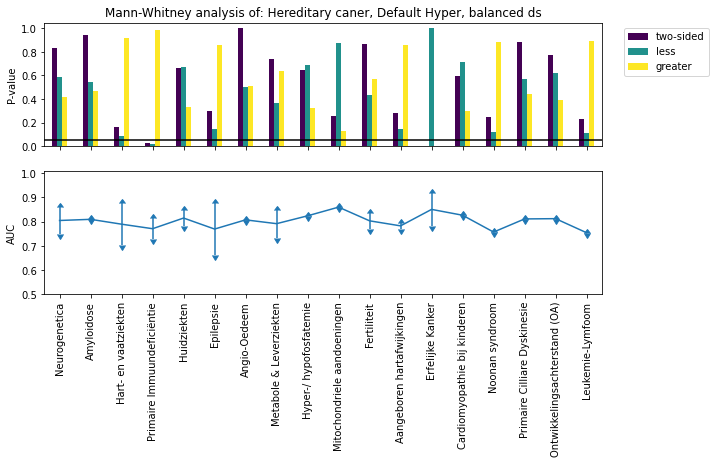

In [184]:
fig, axes = plt.subplots(nrows=2, figsize=(200,100), sharex=True)
umcg_genepanel_analysis.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title=f'Mann-Whitney analysis of: {curr_setup}', ax=axes[0])
axes[0].hlines(y=0.05,xmin=-10,xmax=100)
axes[0].set_ylabel('P-value')
axes[0].set_xlabel('Panel')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.2,1))
axes[1].errorbar(y=y_mean, x=x, yerr=y_std, uplims=True, lolims=True)
axes[1].set_ylabel('AUC')
axes[1].set_ylim((0.5,1.01))
plt.xticks(rotation=90)
plt.show()

In [185]:
categories = umcg_genepanel_analysis['compared_to'].unique()
pallette = viridis(umcg_genepanel_analysis.shape[0])
colormap = dict(zip(categories, pallette))
umcg_genepanel_analysis['color'] = umcg_genepanel_analysis['compared_to'].map(colormap)

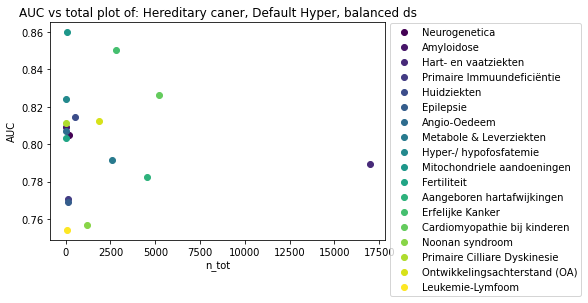

In [186]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_tot'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs total plot of: {curr_setup}')
plt.xlabel('n_tot')
plt.ylabel('AUC')
plt.show()

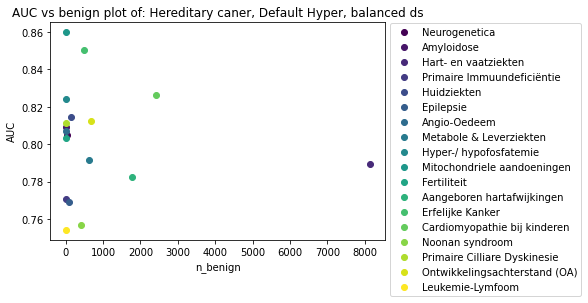

In [187]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_benign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs benign plot of: {curr_setup}')
plt.xlabel('n_benign')
plt.ylabel('AUC')
plt.show()

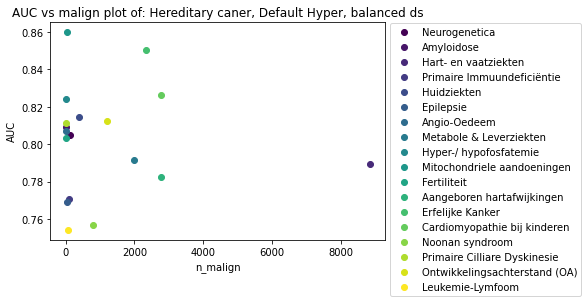

In [188]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_malign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs malign plot of: {curr_setup}')
plt.xlabel('n_malign')
plt.ylabel('AUC')
plt.show()

### Hereditary cancer | Default hyper | unbalanced
[Back](#AUC-analysis-on-Specific-models)

In [189]:
training_set = pd.read_csv('./datafiles/hereditarycancer.txt.gz', sep='\t', low_memory=False)
print(f'There are {training_set.shape[0]} samples in the training set.')

There are 26776 samples in the training set.


In [190]:
curr_setup = 'Hereditary cancer, Default Hyper, unbalanced ds'
train_output = read_capice_output('./test_output/model_2_0/default_hyper/ek/unbalanced/ek_unbalanced_train.txt')
test_output = read_capice_output('./test_output/model_2_0/default_hyper/ek/unbalanced/ek_unbalanced_test.txt')
train_output, test_output = auc_analysis_function(train_output, test_output, return_value=True)

AUC analysis of the training dataset reveals AUC: 0.9412905413097861
AUC analysis of the testing dataset reveals AUC: 0.6887531054718611


In [191]:
train_output['source'] = 'train'
test_output['source'] = 'test'
full = train_output.append(test_output)
full.drop_duplicates(subset=['chr','pos','ref','alt'], inplace=True)
auc_analysis = analyze_auc_per_gene(full, 'auc_analysis_hc_unbalanced.csv')

I am stilling running, done 4%
I am stilling running, done 9%
I am stilling running, done 14%
I am stilling running, done 18%
I am stilling running, done 23%
I am stilling running, done 28%
I am stilling running, done 33%
I am stilling running, done 38%
I am stilling running, done 44%
I am stilling running, done 49%
I am stilling running, done 55%
I am stilling running, done 61%
I am stilling running, done 66%
I am stilling running, done 72%
I am stilling running, done 78%
I am stilling running, done 84%
I am stilling running, done 89%
I am stilling running, done 95%


In [192]:
# The 10 worst performing genes in the new model.

auc_analysis.sort_values(by='auc').head(10)

,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test
1857,PTHLH,0.000000,0.285714,1.0,0.0,0.166667,5,1,6,4,2
286,ASCC1,0.063492,0.000000,0.0,1.0,0.000000,63,1,64,56,8
1576,ABCA13,0.064103,0.000000,0.0,1.0,0.000000,78,1,79,51,28
1681,SAA1,0.131148,0.000000,0.0,1.0,0.000000,61,1,62,61,1
140,ARHGAP29,0.166667,0.428571,1.0,0.0,0.272727,8,3,11,10,1
247,C12orf4,0.181818,0.090909,1.0,0.0,0.047619,22,1,23,18,5
972,ERMAP,0.190476,0.000000,0.0,1.0,0.000000,21,1,22,18,4
162,KIAA0196,0.232026,0.000000,0.0,1.0,0.000000,306,1,307,299,8
862,ANK3,0.236364,0.000000,0.0,1.0,0.000000,110,1,111,106,5
2135,CEACAM16,0.247706,0.000000,0.0,1.0,0.000000,218,1,219,216,3


In [193]:
umcg_genepanel_analysis = genepanel_analysis(genepanels, auc_analysis, is_balanced_loc='./test_output/model_2_0/default_hyper/cardiovascular/balanced/train_balanced_dataset.tsv.gz')
umcg_genepanel_analysis

,two-sided,less,greater,category,compared_to,mean,std,n_benign,n_malign,n_tot,n_train
0,1.342084e-01,0.067104,9.342463e-01,all,Neurogenetica,0.934704,0.030136,45,127,172,172
1,4.161918e-01,0.208096,8.018911e-01,all,Amyloidose,0.928854,0.000000,14,20,34,34
2,9.538471e-02,0.047692,9.532546e-01,all,Hart- en vaatziekten,0.926718,0.054362,8138,8845,16983,16983
3,7.604331e-01,0.624715,3.802166e-01,all,Primaire Immuundeficiëntie,0.952015,0.038302,17,86,103,103
4,3.499341e-02,0.017497,9.830563e-01,all,Huidziekten,0.921944,0.028483,140,383,523,523
5,2.317863e-02,0.011589,9.887351e-01,all,Epilepsie,0.927721,0.029326,85,30,115,115
6,6.206725e-01,0.702030,3.103363e-01,all,Angio-Oedeem,0.967619,0.000000,0,0,0,0
7,6.862262e-01,0.343113,6.634643e-01,all,Metabole & Leverziekten,0.924049,0.055943,623,1976,2599,2599
8,5.716677e-01,0.726062,2.858339e-01,all,Hyper-/ hypofosfatemie,0.968778,0.000000,0,0,0,0
9,6.714216e-01,0.677080,3.357108e-01,all,Mitochondriele aandoeningen,0.965710,0.000000,4,53,57,57


In [194]:
umcg_genepanel_analysis['mean'].mean()

0.941098421064379

In [195]:
y_mean = np.array(umcg_genepanel_analysis['mean'])
y_std = np.array(umcg_genepanel_analysis['std'])
x = np.arange(y_mean.size)

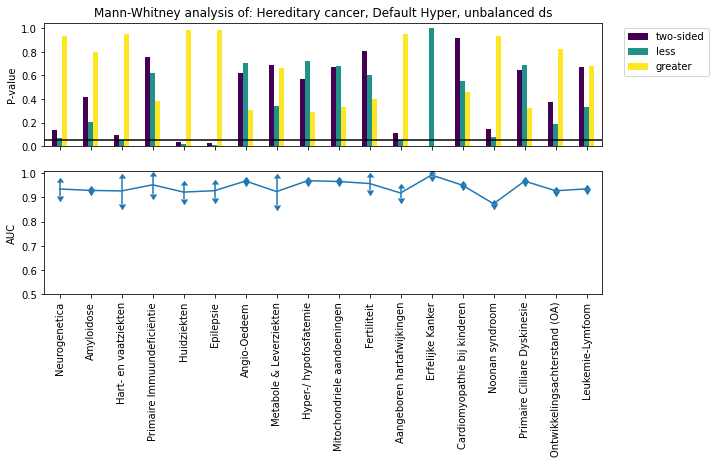

In [196]:
fig, axes = plt.subplots(nrows=2, figsize=(200,100), sharex=True)
umcg_genepanel_analysis.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title=f'Mann-Whitney analysis of: {curr_setup}', ax=axes[0])
axes[0].hlines(y=0.05,xmin=-10,xmax=100)
axes[0].set_ylabel('P-value')
axes[0].set_xlabel('Panel')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.2,1))
axes[1].errorbar(y=y_mean, x=x, yerr=y_std, uplims=True, lolims=True)
axes[1].set_ylabel('AUC')
axes[1].set_ylim((0.5,1.01))
plt.xticks(rotation=90)
plt.show()

In [197]:
categories = umcg_genepanel_analysis['compared_to'].unique()
pallette = viridis(umcg_genepanel_analysis.shape[0])
colormap = dict(zip(categories, pallette))
umcg_genepanel_analysis['color'] = umcg_genepanel_analysis['compared_to'].map(colormap)

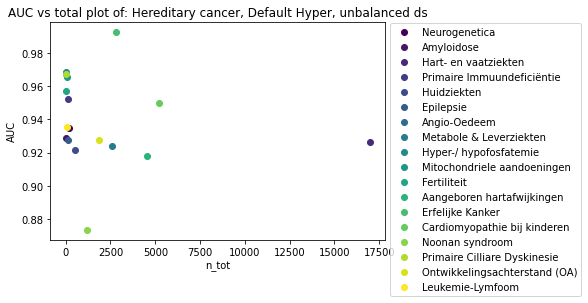

In [198]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_tot'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs total plot of: {curr_setup}')
plt.xlabel('n_tot')
plt.ylabel('AUC')
plt.show()

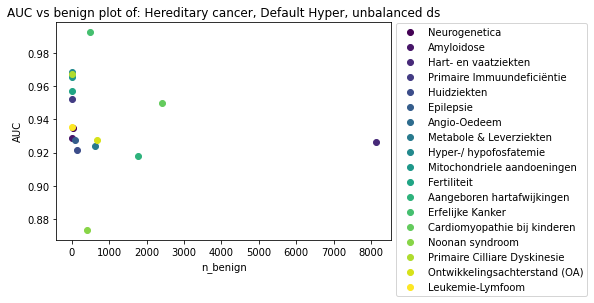

In [199]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_benign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs benign plot of: {curr_setup}')
plt.xlabel('n_benign')
plt.ylabel('AUC')
plt.show()

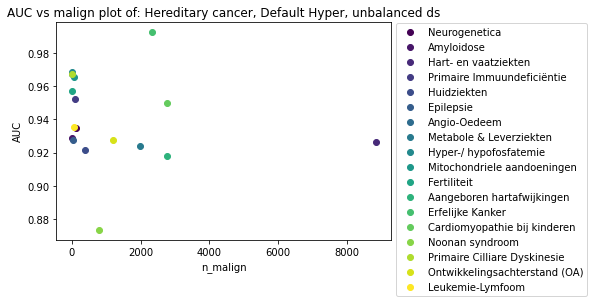

In [200]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_malign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs malign plot of: {curr_setup}')
plt.xlabel('n_malign')
plt.ylabel('AUC')
plt.show()

### Neurogenetics | Default hyper | balanced
[Back](#AUC-analysis-on-Specific-models)

In [201]:
training_set = pd.read_csv('./test_output/model_2_0/default_hyper/neuro/balanced/train_balanced_dataset.tsv.gz', sep='\t', low_memory=False)
print(f'There are {training_set.shape[0]} samples in the training set.')

There are 7196 samples in the training set.


In [202]:
curr_setup = 'Neurogenetics, Default Hyper, balanced ds'
train_output = read_capice_output('./test_output/model_2_0/default_hyper/neuro/balanced/neuro_balanced_train.txt')
test_output = read_capice_output('./test_output/model_2_0/default_hyper/neuro/balanced/neuro_balanced_test.txt')
train_output, test_output = auc_analysis_function(train_output, test_output, return_value=True)

AUC analysis of the training dataset reveals AUC: 0.8092374718518742
AUC analysis of the testing dataset reveals AUC: 0.7111449659394701


In [203]:
train_output['source'] = 'train'
test_output['source'] = 'test'
full = train_output.append(test_output)
full.drop_duplicates(subset=['chr','pos','ref','alt'], inplace=True)
auc_analysis = analyze_auc_per_gene(full, 'auc_analysis_neuro_balanced.csv')

I am stilling running, done 5%
I am stilling running, done 9%
I am stilling running, done 14%
I am stilling running, done 19%
I am stilling running, done 24%
I am stilling running, done 29%
I am stilling running, done 35%
I am stilling running, done 40%
I am stilling running, done 46%
I am stilling running, done 51%
I am stilling running, done 57%
I am stilling running, done 63%
I am stilling running, done 68%
I am stilling running, done 74%
I am stilling running, done 80%
I am stilling running, done 85%
I am stilling running, done 91%
I am stilling running, done 97%


In [204]:
# The 10 worst performing genes in the new model.

auc_analysis.sort_values(by='auc').head(10)

,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test
225,SAA1,0.0,0.000000,0.0,1.0,0.000000,61,1,62,61,1
1634,CXCR4,0.0,0.285714,1.0,0.0,0.166667,5,1,6,5,1
1487,ANK3,0.0,0.000000,0.0,1.0,0.000000,110,1,111,106,5
1505,ALG2,0.0,0.153846,1.0,0.0,0.083333,11,1,12,12,0
1454,EXOSC8,0.0,0.500000,1.0,0.0,0.333333,2,1,3,3,0
1423,MRPS34,0.0,0.800000,1.0,0.0,0.666667,1,2,3,3,0
822,SORD,0.0,0.500000,1.0,0.0,0.333333,2,1,3,2,1
28,ASCC1,0.0,0.030769,1.0,0.0,0.015625,63,1,64,56,8
941,PIGW,0.0,0.857143,1.0,0.0,0.750000,1,3,4,4,0
1957,ERMAP,0.0,0.000000,0.0,1.0,0.000000,21,1,22,18,4


In [205]:
umcg_genepanel_analysis = genepanel_analysis(genepanels, auc_analysis, is_balanced_loc='./test_output/model_2_0/default_hyper/cardiovascular/balanced/train_balanced_dataset.tsv.gz')
umcg_genepanel_analysis

,two-sided,less,greater,category,compared_to,mean,std,n_benign,n_malign,n_tot,n_train
0,0.000020,0.999990,0.000010,all,Neurogenetica,0.903884,0.029086,45,127,172,172
1,0.804561,0.611334,0.402280,all,Amyloidose,0.854218,0.000000,14,20,34,34
2,0.099265,0.049632,0.951345,all,Hart- en vaatziekten,0.809656,0.098196,8138,8845,16983,16983
3,0.302301,0.851870,0.151151,all,Primaire Immuundeficiëntie,0.867170,0.035068,17,86,103,103
4,0.850769,0.425385,0.579695,all,Huidziekten,0.843121,0.021873,140,383,523,523
5,0.024525,0.988078,0.012263,all,Epilepsie,0.834532,0.168755,85,30,115,115
6,0.111668,0.055834,0.948035,all,Angio-Oedeem,0.657143,0.000000,0,0,0,0
7,0.739766,0.369883,0.636875,all,Metabole & Leverziekten,0.827674,0.050792,623,1976,2599,2599
8,0.416192,0.801891,0.208096,all,Hyper-/ hypofosfatemie,0.881451,0.000000,0,0,0,0
9,0.339858,0.838863,0.169929,all,Mitochondriele aandoeningen,0.889872,0.000000,4,53,57,57


In [206]:
umcg_genepanel_analysis['mean'].mean()

0.8227695577763253

In [207]:
y_mean = np.array(umcg_genepanel_analysis['mean'])
y_std = np.array(umcg_genepanel_analysis['std'])
x = np.arange(y_mean.size)

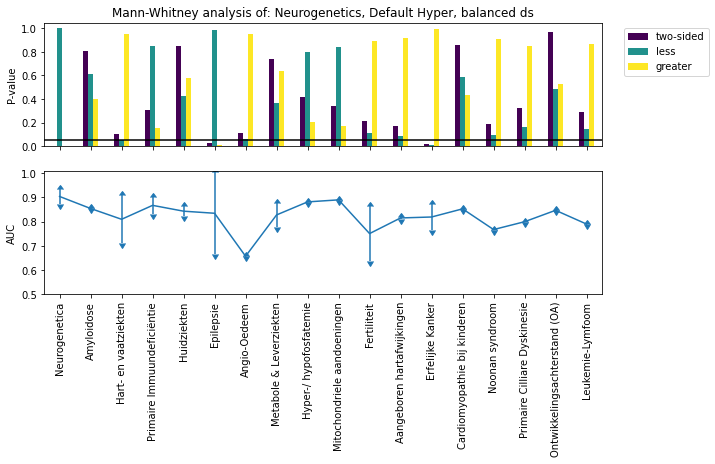

In [208]:
fig, axes = plt.subplots(nrows=2, figsize=(200,100), sharex=True)
umcg_genepanel_analysis.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title=f'Mann-Whitney analysis of: {curr_setup}', ax=axes[0])
axes[0].hlines(y=0.05,xmin=-10,xmax=100)
axes[0].set_ylabel('P-value')
axes[0].set_xlabel('Panel')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.2,1))
axes[1].errorbar(y=y_mean, x=x, yerr=y_std, uplims=True, lolims=True)
axes[1].set_ylabel('AUC')
axes[1].set_ylim((0.5,1.01))
plt.xticks(rotation=90)
plt.show()

In [209]:
categories = umcg_genepanel_analysis['compared_to'].unique()
pallette = viridis(umcg_genepanel_analysis.shape[0])
colormap = dict(zip(categories, pallette))
umcg_genepanel_analysis['color'] = umcg_genepanel_analysis['compared_to'].map(colormap)

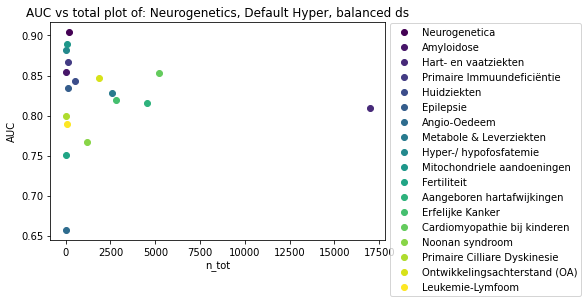

In [210]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_tot'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs total plot of: {curr_setup}')
plt.xlabel('n_tot')
plt.ylabel('AUC')
plt.show()

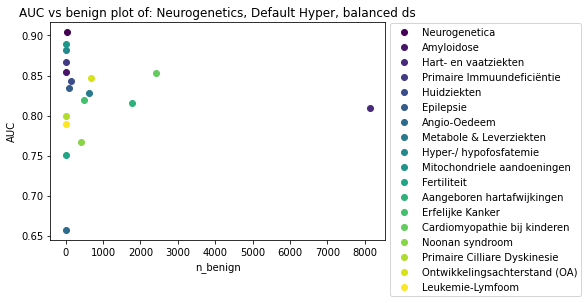

In [211]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_benign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs benign plot of: {curr_setup}')
plt.xlabel('n_benign')
plt.ylabel('AUC')
plt.show()

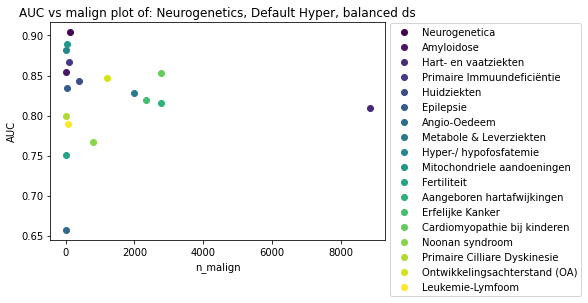

In [212]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_malign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs malign plot of: {curr_setup}')
plt.xlabel('n_malign')
plt.ylabel('AUC')
plt.show()

### Neurogenetics | Default hyper | unbalanced
[Back](#AUC-analysis-on-Specific-models)

In [213]:
training_set = pd.read_csv('./datafiles/neurogenetics.txt.gz', sep='\t', low_memory=False)
print(f'There are {training_set.shape[0]} samples in the training set.')

There are 29769 samples in the training set.


In [214]:
curr_setup = 'Neurogenetics, Default Hyper, unbalanced ds'
train_output = read_capice_output('./test_output/model_2_0/default_hyper/neuro/unbalanced/neuro_unbalanced_train.txt')
test_output = read_capice_output('./test_output/model_2_0/default_hyper/neuro/unbalanced/neuro_unbalanced_test.txt')
train_output, test_output = auc_analysis_function(train_output, test_output, return_value=True)

AUC analysis of the training dataset reveals AUC: 0.9481378355038539
AUC analysis of the testing dataset reveals AUC: 0.6842703096898413


In [215]:
train_output['source'] = 'train'
test_output['source'] = 'test'
full = train_output.append(test_output)
full.drop_duplicates(subset=['chr','pos','ref','alt'], inplace=True)
auc_analysis = analyze_auc_per_gene(full, 'auc_analysis_neuro_unbalanced.csv')

I am stilling running, done 4%
I am stilling running, done 9%
I am stilling running, done 14%
I am stilling running, done 18%
I am stilling running, done 23%
I am stilling running, done 28%
I am stilling running, done 33%
I am stilling running, done 39%
I am stilling running, done 45%
I am stilling running, done 51%
I am stilling running, done 56%
I am stilling running, done 62%
I am stilling running, done 68%
I am stilling running, done 74%
I am stilling running, done 80%
I am stilling running, done 86%
I am stilling running, done 91%
I am stilling running, done 97%


In [216]:
# The 10 worst performing genes in the new model.

auc_analysis.sort_values(by='auc').head(10)

,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test
2334,TRAF3IP1,0.000000,0.000000,0.0,1.0,0.000000,3,1,4,4,0
1674,PTHLH,0.000000,0.285714,1.0,0.0,0.166667,5,1,6,4,2
28,ASCC1,0.031746,0.000000,0.0,1.0,0.000000,63,1,64,56,8
1499,KITLG,0.095238,0.000000,0.0,1.0,0.000000,21,1,22,22,0
1104,CA4,0.117647,0.000000,0.0,1.0,0.000000,153,1,154,153,1
1797,SAA1,0.180328,0.000000,0.0,1.0,0.000000,61,1,62,61,1
968,ERMAP,0.190476,0.000000,0.0,1.0,0.000000,21,1,22,18,4
913,HIST1H1E,0.200000,0.333333,1.0,0.0,0.200000,5,1,6,5,1
2263,TNC,0.204947,0.000000,0.0,1.0,0.000000,283,1,284,278,6
2235,ABCA13,0.205128,0.000000,0.0,1.0,0.000000,78,1,79,51,28


In [217]:
umcg_genepanel_analysis = genepanel_analysis(genepanels, auc_analysis, is_balanced_loc='./test_output/model_2_0/default_hyper/cardiovascular/balanced/train_balanced_dataset.tsv.gz')
umcg_genepanel_analysis

,two-sided,less,greater,category,compared_to,mean,std,n_benign,n_malign,n_tot,n_train
0,0.000002,0.999999,0.000001,all,Neurogenetica,0.991487,0.014114,45,127,172,172
1,0.595941,0.297970,0.714166,all,Amyloidose,0.942377,0.000000,14,20,34,34
2,0.044043,0.022022,0.978478,all,Hart- en vaatziekten,0.924983,0.065052,8138,8845,16983,16983
3,0.701896,0.653850,0.350948,all,Primaire Immuundeficiëntie,0.959574,0.032319,17,86,103,103
4,0.036130,0.018065,0.982503,all,Huidziekten,0.933086,0.023070,140,383,523,523
5,0.652883,0.326442,0.677456,all,Epilepsie,0.935981,0.079326,85,30,115,115
6,0.168005,0.084002,0.921318,all,Angio-Oedeem,0.908889,0.000000,0,0,0,0
7,0.424299,0.212149,0.793019,all,Metabole & Leverziekten,0.924316,0.062216,623,1976,2599,2599
8,0.804561,0.611334,0.402280,all,Hyper-/ hypofosfatemie,0.967774,0.000000,0,0,0,0
9,0.697389,0.664289,0.348694,all,Mitochondriele aandoeningen,0.970772,0.000000,4,53,57,57


In [218]:
umcg_genepanel_analysis['mean'].mean()

0.9418728210651172

In [219]:
y_mean = np.array(umcg_genepanel_analysis['mean'])
y_std = np.array(umcg_genepanel_analysis['std'])
x = np.arange(y_mean.size)

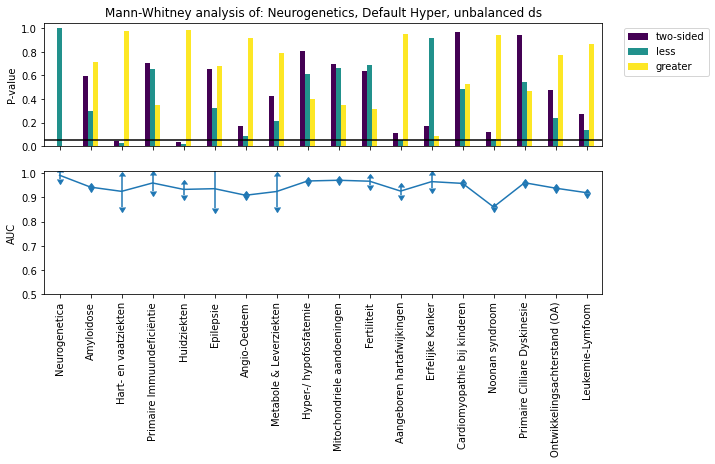

In [220]:
fig, axes = plt.subplots(nrows=2, figsize=(200,100), sharex=True)
umcg_genepanel_analysis.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title=f'Mann-Whitney analysis of: {curr_setup}', ax=axes[0])
axes[0].hlines(y=0.05,xmin=-10,xmax=100)
axes[0].set_ylabel('P-value')
axes[0].set_xlabel('Panel')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.2,1))
axes[1].errorbar(y=y_mean, x=x, yerr=y_std, uplims=True, lolims=True)
axes[1].set_ylabel('AUC')
axes[1].set_ylim((0.5,1.01))
plt.xticks(rotation=90)
plt.show()

In [221]:
categories = umcg_genepanel_analysis['compared_to'].unique()
pallette = viridis(umcg_genepanel_analysis.shape[0])
colormap = dict(zip(categories, pallette))
umcg_genepanel_analysis['color'] = umcg_genepanel_analysis['compared_to'].map(colormap)

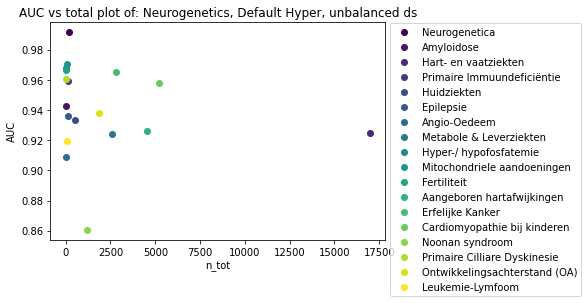

In [222]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_tot'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs total plot of: {curr_setup}')
plt.xlabel('n_tot')
plt.ylabel('AUC')
plt.show()

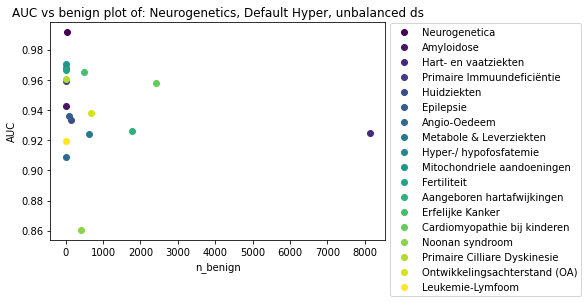

In [223]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_benign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs benign plot of: {curr_setup}')
plt.xlabel('n_benign')
plt.ylabel('AUC')
plt.show()

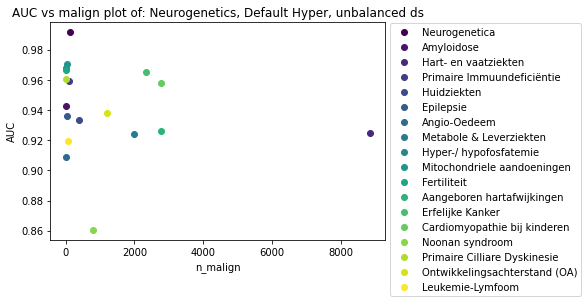

In [224]:
fig = plt.figure()
for compared_to in umcg_genepanel_analysis['compared_to'].values:
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['compared_to'] == compared_to]
    x = subset['n_malign'].values
    y = subset['mean'].values
    color = subset['color'].values
    plt.scatter(x,y, c=color, label=compared_to)    
plt.legend(loc='lower right', bbox_to_anchor=(1.6,-0.28))
plt.title(f'AUC vs malign plot of: {curr_setup}')
plt.xlabel('n_malign')
plt.ylabel('AUC')
plt.show()

# Model on best performing panel, prepartation
[Index](#Index)

In [102]:
ek = genepanels['Erfelijke Kanker']
ek

{'Borstkanker': ['ATM', 'BRCA1', 'BRCA2', 'CHEK2', 'PALB2'],
 'Borstkanker & Li Fraumeni syndroom': ['ATM',
  'BRCA1',
  'BRCA2',
  'CHEK2',
  'PALB2',
  'TP53'],
 'Darmkanker': ['EPCAM',
  'MLH1',
  'MSH2',
  'MSH6',
  'MUTYH',
  'PMS2',
  'POLD1',
  'POLE'],
 'Darmpoliepen': ['APC',
  'AXIN2',
  'BMPR1A',
  'ENG',
  'MSH3',
  'MUTYH',
  'NTHL1',
  'POLD1',
  'POLE',
  'PTEN',
  'RNF43',
  'SMAD4',
  'SMAD4',
  'STK11'],
 'Eierstokkanker': ['BRCA1',
  'BRCA2',
  'BRIP1',
  'EPCAM',
  'MLH1',
  'MSH2',
  'MSH6',
  'PMS2',
  'RAD51C',
  'RAD51D'],
 'Endocrinologie-feochromocytomen': ['FH',
  'MAX',
  'MDH2',
  'NF1',
  'RET',
  'SDHA',
  'SDHAF2',
  'SDHB',
  'SDHC',
  'SDHD',
  'TMEM127',
  'VHL'],
 'Endocrinologie-NET': ['AIP',
  'CDKN1A',
  'CDKN1B',
  'CDKN2B',
  'CDKN2C',
  'MEN1',
  'NF1',
  'PRKAR1A'],
 'Huidkanker': ['ACD',
  'ACTRT1',
  'BAP1',
  'CDK4',
  'CDKN2A',
  'ERCC2',
  'MITF',
  'POLH',
  'POT1',
  'PTCH1',
  'PTCH2',
  'SUFU',
  'TERF2IP',
  'TERT'],
 'Kinderonco-med

In [103]:
ek_genes = []
for key, values in ek.items():
    for value in values:
        if value not in ek_genes:
            ek_genes.append(value)
len(ek_genes)

87

In [104]:
ek_subset = train.loc[train['GeneName'].isin(ek_genes)]
ek_subset

,#Chrom,Allergy/Immunology/Infectious,Alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,revel,sift,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight
55,2,False,A,CodingTranscript,False,False,CCDS1836.1,741.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.839,-0.283,False,1.0
56,2,False,TA,CodingTranscript,False,False,CCDS1836.1,1944.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,True,0.001,0.466,False,1.0
57,2,False,CC,CodingTranscript,False,False,CCDS1836.1,3259.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,True,1.000,3.249,False,1.0
58,2,False,C,CodingTranscript,False,False,CCDS1836.1,102.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.000,-0.743,False,1.0
59,2,False,AT,CodingTranscript,False,False,CCDS1836.1,395.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,True,1.000,5.138,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334504,5,False,T,CodingTranscript,False,False,CCDS4107.1,3925.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,3.528,False,0.8
334505,5,False,GACAAAGA,CodingTranscript,False,False,CCDS4107.1,4160.0,False,"frameshift,stop_gained",...,NaN,NaN,unknown,NaN,NaN,False,1.000,5.909,False,0.8
334533,17,False,A,CodingTranscript,False,False,CCDS45646.1,271.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.003,0.639,False,0.8
334534,17,False,A,CodingTranscript,False,False,CCDS45646.1,184.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.003,0.266,False,0.8


In [105]:
ek_subset['label'].value_counts()

Benign        16869
Pathogenic     9907
Name: label, dtype: int64

# AUC analysis new model on UMCG genepanels
[Index](#Index)

In [106]:
auc_analysis

,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test
0,BRCA1,0.998579,0.977767,0.998452,0.001548,0.957921,849,1938,2787,2226,561
1,LDLR,0.997713,0.970551,0.993881,0.006119,0.948290,336,1144,1480,1325,155
2,MSH2,0.998786,0.970281,0.996700,0.003300,0.945227,390,606,996,850,146
3,BRCA2,0.999336,0.973060,0.999174,0.000826,0.948276,1221,2422,3643,2973,670
4,USH2A,0.995784,0.909589,0.988095,0.011905,0.842640,312,168,480,459,21
...,...,...,...,...,...,...,...,...,...,...,...
2349,HINT1,1.000000,0.000000,0.000000,1.000000,0.000000,5,1,6,5,1
2350,APOA1,1.000000,1.000000,1.000000,0.000000,1.000000,9,1,10,9,1
2351,SGSM3,1.000000,1.000000,1.000000,0.000000,1.000000,3,1,4,3,1
2352,IL2RG,1.000000,1.000000,1.000000,0.000000,1.000000,6,1,7,6,1


In [107]:
genepanel_auc = genepanel_analysis(genepanels, auc_analysis)
genepanel_auc.sort_values(by='compared_to', inplace=True)

In [108]:
previous_model_auc = pd.read_csv('./not_saving_directory/previousmodelauc.csv')
previous_model_auc.sort_values(by='compared_to', inplace=True)

Text(0.5, 0, 'Panel')

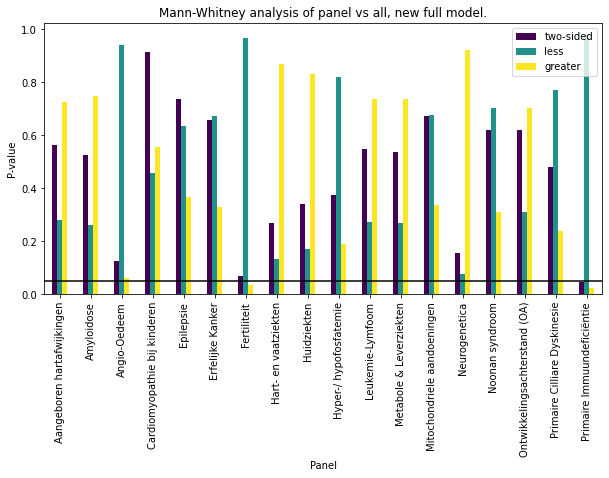

In [109]:
ax = genepanel_auc.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title='Mann-Whitney analysis of panel vs all, new full model.')
ax.hlines(y=0.05,xmin=-10,xmax=100)
ax.set_ylabel('P-value')
ax.set_xlabel('Panel')

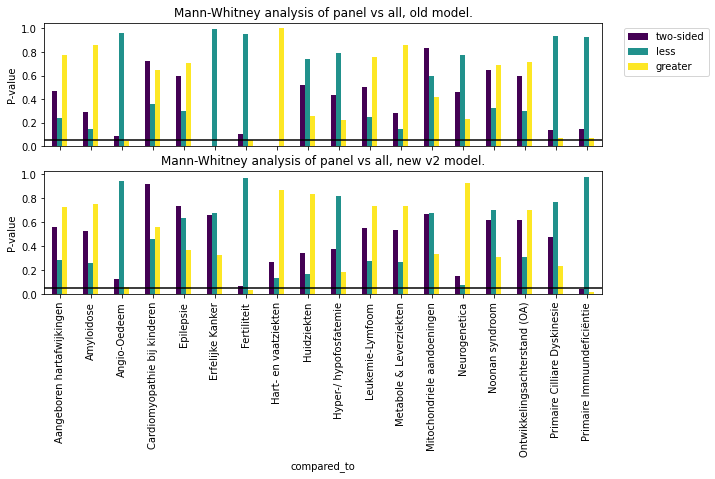

In [110]:
fig, axes = plt.subplots(nrows=2, figsize=(200,100), sharex=True)
previous_model_auc.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title='Mann-Whitney analysis of panel vs all, old model.', ax=axes[0])
axes[0].hlines(y=0.05,xmin=-10,xmax=100)
axes[0].set_ylabel('P-value')
axes[0].set_xlabel('Panel')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.2,1))
genepanel_auc.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title='Mann-Whitney analysis of panel vs all, new v2 model.', ax=axes[1])
axes[1].get_legend().remove()
axes[1].set_ylabel('P-value')
axes[1].hlines(y=0.05,xmin=-10,xmax=100)

# Corrected UMCG genepanel analysis
[Index](#Index)

# Barplot of type of variants for each panel
[Index](#Index)

In [111]:
variants = pd.read_csv('/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/datafiles/train.txt.gz', compression='gzip', sep='\t', low_memory=False)
variants

,#Chrom,Allergy/Immunology/Infectious,Alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,revel,sift,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight
0,14,False,G,CodingTranscript,False,False,CCDS9787.1,806.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,5.843,False,1.0
1,20,False,T,CodingTranscript,True,False,CCDS13112.1,1899.0,True,"frameshift,stop_gained",...,NaN,NaN,vkgl,NaN,NaN,False,1.000,4.670,False,1.0
2,20,False,C,CodingTranscript,True,False,CCDS13112.1,2118.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,5.043,False,1.0
3,20,False,A,CodingTranscript,True,False,CCDS13112.1,1586.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,6.221,False,1.0
4,20,False,A,Intergenic,True,False,NaN,NaN,True,downstream,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,6.368,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334596,17,False,A,CodingTranscript,False,False,CCDS32642.1,1563.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,6.031,False,0.8
334597,17,False,T,CodingTranscript,False,False,CCDS32642.1,2029.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,4.100,False,0.8
334598,10,False,T,CodingTranscript,False,False,CCDS7431.1,1216.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,5.852,False,0.8
334599,2,False,T,CodingTranscript,False,False,CCDS2382.1,2998.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.031,2.213,False,0.8


Text(0.5, 0, 'Consequence')

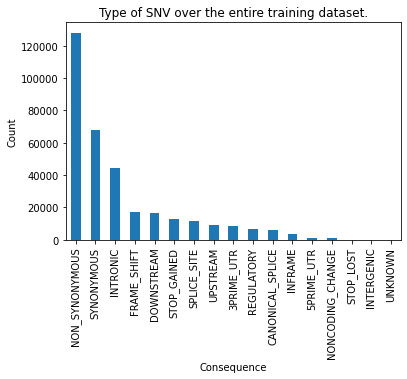

In [112]:
ax = variants['Consequence'].value_counts().plot(kind='bar')
ax.set_title('Type of SNV over the entire training dataset.')
ax.set_ylabel('Count')
ax.set_xlabel('Consequence')

In [113]:
# Reduce the information to just panels.

panels = {}
for panel in genepanels.keys():
    panels[panel] = []
    disease_panel = genepanels[panel]
    if isinstance(disease_panel, dict):
        for disease, genes in disease_panel.items():
            for gene in genes:
                if gene not in panels[panel]:
                    panels[panel].append(gene)

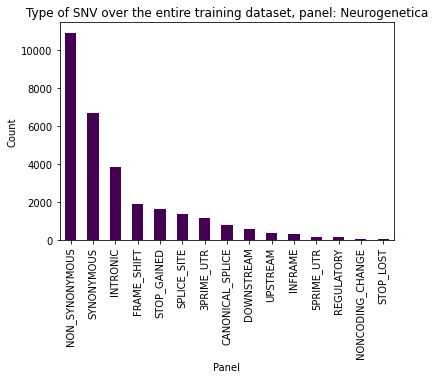

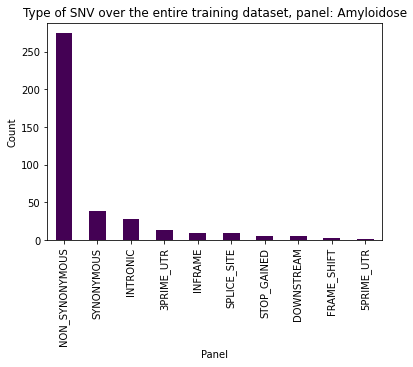

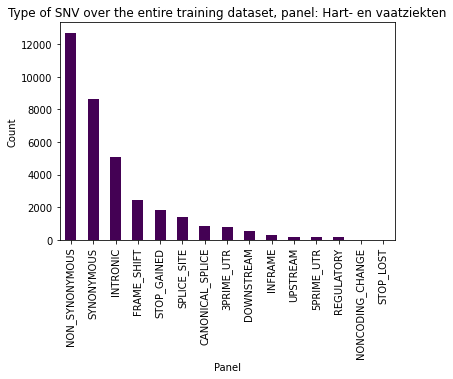

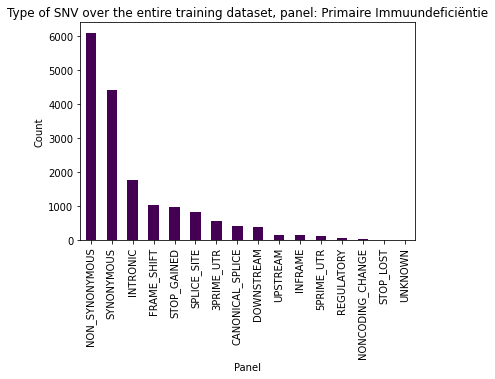

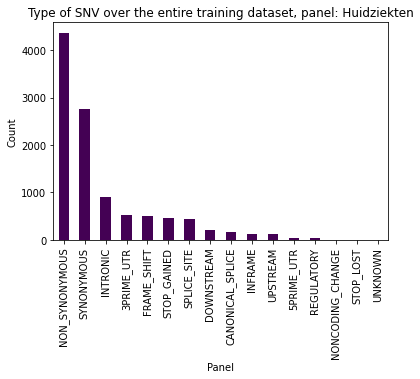

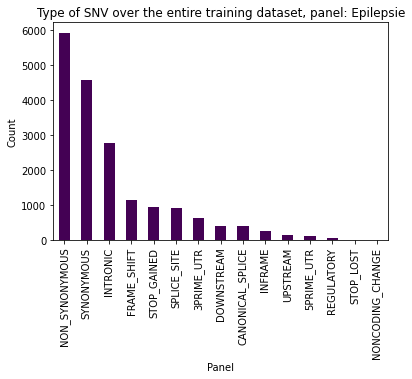

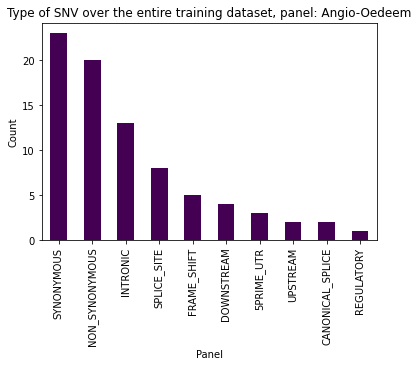

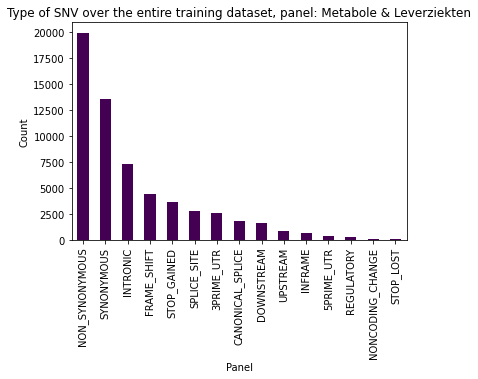

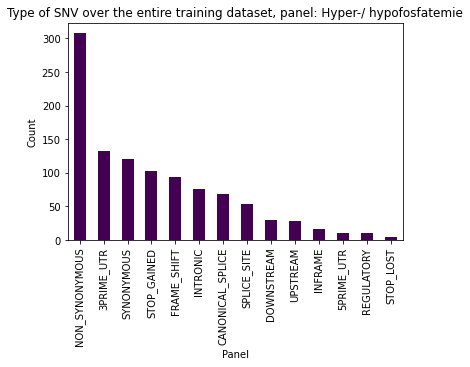

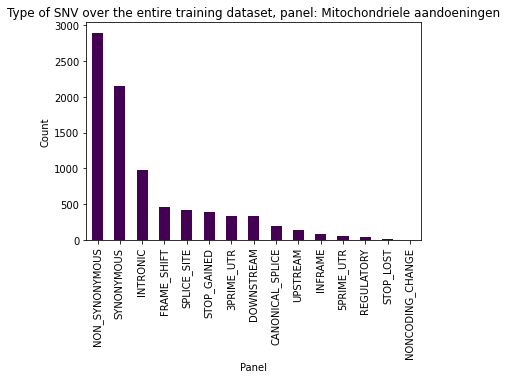

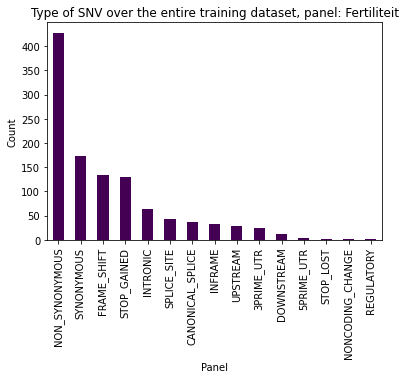

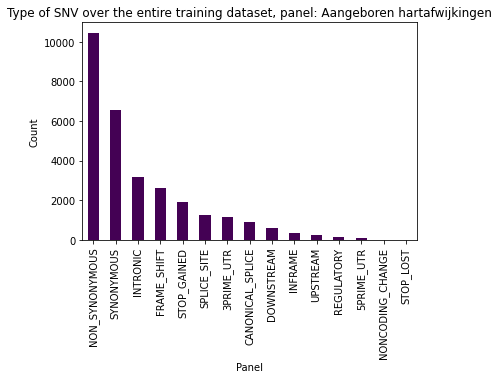

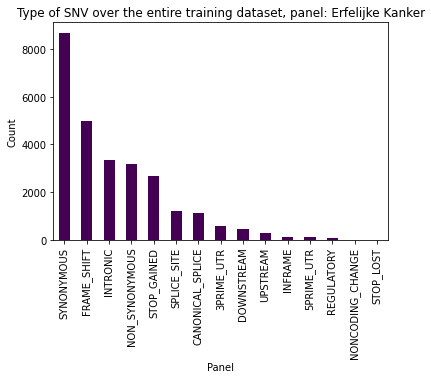

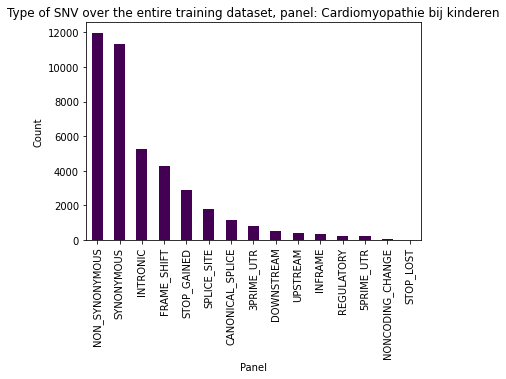

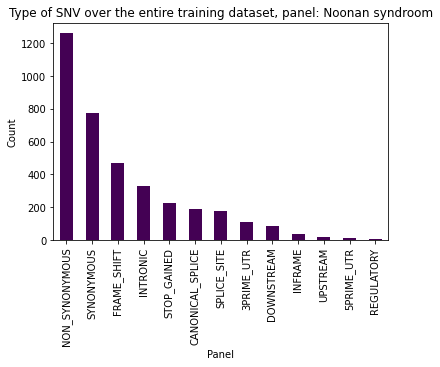

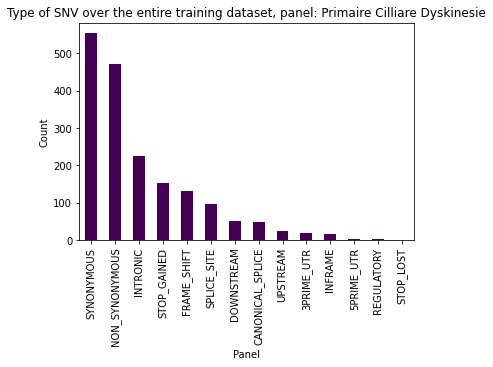

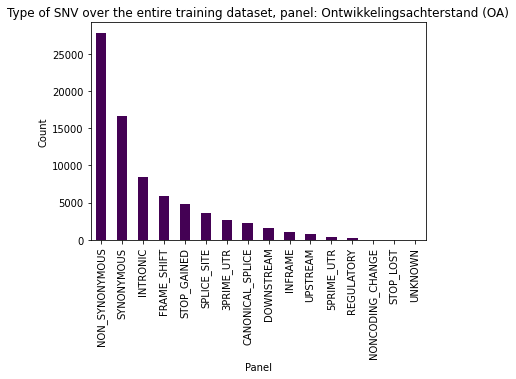

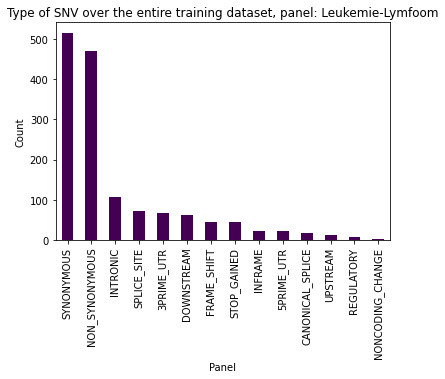

In [114]:
for panel, genes in panels.items():
    title = f'Type of SNV over the entire training dataset, panel: {panel}'
    subset = variants[variants['GeneName'].isin(genes)]
    data = subset['Consequence'].value_counts()
    ax = data.plot.bar(x='index', y='Consequence',
                      colormap='viridis',
                      title=title)
    ax.set_ylabel('Count')
    ax.set_xlabel('Panel')
    fig = plt.Figure()
    fig.axes.append(ax)
    plt.show()